In [1]:
# Needed for functions
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import time

# Import Qiskit Classes
from qiskit import *
from qiskit import IBMQ
from qiskit import transpile
from qiskit.providers.aer import AerSimulator, QasmSimulator, noise
from qiskit.providers.aer.extensions import *
from qiskit import quantum_info as qi
from qiskit.test.mock import FakeBogota, FakeSantiago
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
import qiskit.ignis.mitigation.measurement as mc

# Import Visualization Tools
from qiskit.tools.visualization import plot_histogram as plth
from qiskit.visualization import plot_state_city, plot_state_hinton
from qiskit.tools.monitor import job_monitor
from qiskit.tools.jupyter import *


In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')


In [3]:
qcomp_M = provider.get_backend('ibmq_manila')
qcomp_M

<IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>

In [4]:
qcomp_B = provider.get_backend('ibmq_bogota')
qcomp_B

<IBMQBackend('ibmq_bogota') from IBMQ(hub='ibm-q', group='open', project='main')>

In [5]:
qcomp_S = provider.get_backend('ibmq_santiago')
qcomp_S

<IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>

In [6]:
qcomp_sim_B = AerSimulator.from_backend(FakeBogota())
FakeBogota()

<FakeBogota('fake_bogota') from None()>

In [7]:
qcomp_sim_S = AerSimulator.from_backend(FakeSantiago())
FakeSantiago()

<FakeSantiago('fake_santiago') from None()>

In [8]:
# Parametros libres globales
p_amp = 0.05
p_phs = 0.05
p_dprz = 0.05
shots = 8192

# Funcion para construir el circuito de codificación de 4 qubits para estados de Bell
def codBell(creg = True):
    """
    Función que construye los pasos para realizar una codificación de 4
    qubits sobre un grafo de tipo l para obtener un estado de Bell entre
    sus extremos, usando un circuito construido mediante la teoría de QLNC.
    
    PARAMETROS:
        creg: Variable de tipo Booleano, para añadir o no un registro clásico.
        
    SALIDAS:
        qc: Circuito de la codificación.
    """
    qr = QuantumRegister(4, 'q')
    if creg:
        cr = ClassicalRegister(2, 'c')
        qc = QuantumCircuit(qr, cr)
    else:
        qc = QuantumCircuit(qr)

    qc.h([0, 2])

    qc.barrier()

    qc.cnot(2, 1)
    qc.cnot(2, 3)
    qc.cnot(0, 1)

    qc.barrier()

    qc.h([2])
    qc.cnot(1, 0)
    qc.cz(2, 3)
    qc.barrier()

    return qc

# Funcion para construir el circuito de codificación de 5 qubits para estados GHZ
def codGHZ(creg = True):
    """
    Función que construye los pasos para realizar una codificación de 5
    qubits sobre un grado de tipo L para obtener un estado GHZ, usando
    un circuito construido mediante la teoría de QLNC.
    
    PARAMETROS:
        creg: Variable de tipo Booleano, para añadir o no un registro clásico.
        
    SALIDAS:
        qc: Circuito de la codificación.
    """
    qr = QuantumRegister(5, 'q')
    if creg:
        cr = ClassicalRegister(3, 'c')
        qc = QuantumCircuit(qr, cr)
    else:
        qc = QuantumCircuit(qr)

    qc.h([0, 2, 4])

    qc.barrier()

    qc.cnot([2, 4], [1, 3])
    qc.cnot([0, 2], [1, 3])

    qc.barrier()

    qc.cnot([1, 3], [0, 4])
    qc.barrier()

    return qc

# Función para ruido de Amplitud Damping
def amp_noise(p):
    """
    Funcion que sirve para crear un modelo ruidoso basado en Amplitud Damping
    y devolverlo al usuario, las operaciones sobre un solo qubit afectadas son
    rotación en z, raíz de X, rotación en 3 grados y el operador X, mientras
    que las operaciones sobre 2 qubits afectadas son las puertas X y Z controladas.
    
    PARAMETROS:
        p: Probabilidad de aplicar el efecto del ruido sobre el estado.
        
    SALIDAS:
        noisy_model_dprz: Modelo de ruido completo.
    """
    noise_amp_1 = noise.amplitude_damping_error(p)
    noise_amp_2 = noise_amp_1.tensor(noise_amp_1)
    # Modelo Ruidoso de Amplitud Damping
    noisy_model_amp = noise.NoiseModel()
    noisy_model_amp.add_all_qubit_quantum_error(noise_amp_1,
                                                ['rz', 'sx', 'x', 'u3'])
    noisy_model_amp.add_all_qubit_quantum_error(noise_amp_2,
                                                ['cx', 'cz'])
    return noisy_model_amp

# Función para ruido de Depolarizing
def phs_noise(p):
    """
    Crea un modelo ruidoso basado en Phase Damping y devolverlo al usuario,
    las operaciones sobre un solo qubit afectadas son rotación en z, raíz
    de X, rotación en 3 grados y el operador X, mientras que las operaciones
    sobre 2 qubits afectadas son las puertas X y Z controladas.
    
    PARAMETROS:
        p: Probabilidad de aplicar el efecto del ruido sobre el estado.
        
    SALIDAS:
        noisy_model_dprz: Modelo de ruido completo.
    """
    noise_phs_1 = noise.phase_damping_error(p)
    noise_phs_2 = noise_phs_1.tensor(noise_phs_1)
    # Modelo Ruidoso de Phase Damping
    noisy_model_phs = noise.NoiseModel()
    noisy_model_phs.add_all_qubit_quantum_error(noise_phs_1,
                                                ['rz', 'sx', 'x', 'u3'])
    noisy_model_phs.add_all_qubit_quantum_error(noise_phs_2,
                                                ['cx', 'cz'])
    return noisy_model_phs

# Función para ruido de Depolarizing
def dprz_noise(p):
    """
    Crea un modelo ruidoso basado en Depolarizing y devolverlo al usuario,
    las operaciones sobre un solo qubit afectadas son rotación en z, raíz
    de X, rotación en 3 grados y el operador X, mientras que las operaciones
    sobre 2 qubits afectadas son las puertas X y Z controladas.
    
    PARAMETROS:
        p: Probabilidad de aplicar el efecto del ruido sobre el estado.
        
    SALIDAS:
        noisy_model_dprz: Modelo de ruido completo.
    """
    noise_dprz_1 = noise.depolarizing_error(p, 1)
    noise_dprz_2 = noise.depolarizing_error(p, 2)
    # Modelo Ruidoso de Depolarizing
    noisy_model_dprz = noise.NoiseModel()
    noisy_model_dprz.add_all_qubit_quantum_error(noise_dprz_1,
                                                 ['rz', 'sx', 'x', 'u3'])
    noisy_model_dprz.add_all_qubit_quantum_error(noise_dprz_2,
                                                 ['cx', 'cz'])
    return noisy_model_dprz

#Función para calcular la fidelidad
def fid(qc, qc_noise, noise_model, shots):
    """
    Calcular la fidelidad cuántica entre 2 circuitos, uno ideal y otro con
    ruido. Como el simulador de estados incluido en QISKit realiza n cantidad
    de corridas, es necesario calcular la fidelidad individual de cada una y
    después promediar el resultado para luego devolverlo al usuario.
    
    PARAMETROS:
        qc: Circuito sin ruido.
        qc_noise: Circuito con ruido.
        noise_model: Modelo del ruido.
        shots: Número de simulaciones.
    SALIDAS:
        f/j: Promedio de las fidelidades calculadas en cada corrida.
    """
    
    f = 0
    j = 0
    
    sv_qc = qc.copy()
    sv_qc.snapshot_statevector('final')
    sv = execute(sv_qc, QasmSimulator()).result().data(0)['snapshots']['statevector']['final'][0]

    #Circuitos simulados con el ruido clasico
    sv_qc_noise = qc_noise.copy()
    sv_qc_noise.snapshot_statevector('final')
    sv_noise = execute(sv_qc_noise, QasmSimulator(), shots=shots, noise_model=noise_model,
                       basis_gates=noise_model.basis_gates
                      ).result().data(0)['snapshots']['statevector']['final']
    for i in range (0, len(sv_noise)):
        if np.round(abs(sum([n ** 2 for n in sv_noise[i]])),4)==1.0000:
            j += 1
            f += qi.state_fidelity(sv, sv_noise[i])
            
    
    return f/j

#Función para calcular la matriz densidad usando tomografía
def tomo(qc, backend, qubits=[], cal_id = [], tomo_id = [], trans=True):
    """
    Calcular la matriz densidad de un circuito cuántico a partir de
    los resultados experimentales en forma de probabilidades, usando
    el método de tomografía cuántica con la subrutina de mitigación
    de errores en la medida mediante la calibración de un filtro
    construido a partir de los resultados en el error por cada posible
    combinación del registro cuántico.
    
    PARAMETROS:
        qc: Circuito cuántico.
        backend: Backend del dispositivo que se esté utilizando.
        qubits: Lista con los qubits relacionados a la medida
        cal_id: Lista con los marcadores en el backend de los circuitos
            para calibración.
        tomo_id: Lista con los marcadores en el backend de los circuitos
            para calcular la tomografía.
        transpile: Variable de tipo booleana para determinar si hay o no
            que transpilar el circuito. Especialmente útil para simular
            ruidos.
        noise: Lista con los modelos de ruido a aplicar durante la tomo-
            grafía.
    SALIDAS:
        P: 
            Matriz densidad obtenida sin filtrar el ruido.
        job_tomo.result().time_taken/60: 
            Tiempo de ejecución de los circuitos para la tomografía
            dentro del backend.
        P_mit: 
            Matriz densidad obtenida sin filtrar el ruido.
        (job_cal.result().time_taken+job_tomo.result().time_taken)/60: 
            Tiempo de ejecución de los circuitos para  la tomografía
            y calibración del filtro dentro del backend.
    """
        
    # Generate Circuits and Fitter for Calibration tomography.
    if trans:
        tqc_tomo = transpile(qc, backend)
    else:
        tqc_tomo = qc.copy()

    if len(qubits)==0:
        qst_tqc = state_tomography_circuits(tqc_tomo,
                                            tqc_tomo.qubits)
        meas_cal, state_labels = mc.complete_meas_cal(tqc_tomo.qubits)

    else:
        qst_tqc = state_tomography_circuits(tqc_tomo,
                                            qubits)
        meas_cal, state_labels = mc.complete_meas_cal(qubits)

    
    # Execute Job callibrated and not
    if len(cal_id)==0:
        if len(meas_cal)<100:
            job_cal = qiskit.execute(meas_cal, backend=backend, shots=shots)
        else:
            i=100
            job_cal = qiskit.execute(meas_cal[i-100:i], backend=backend, shots=shots)
            while True:
                i+=100
                if(i > len(meas_cal)):
                    print(i)
                    job = qiskit.execute(meas_cal[i-100:len(qst_tqc)],
                                         backend=backend,
                                         shots=shots).result()
                    
                    job_cal.result().results += job.results
                    job_cal.result().time_taken += job.time_taken
                    
                    break
                job = qiskit.execute(meas_cal[i-100:i],
                                     backend=backend,
                                     shots=shots).result()
                
                job_cal.result().results += job.results
                job_cal.result().time_taken += job.time_taken
                    
    else:
        job_cal = backend.retrieve_job(cal_id.pop(0))
        while len(cal_id)!=0:
            job = backend.retrieve_job(cal_id.pop(0)).result()
            
            job_cal.result().results += job.results
            job_cal.result().results += job.time_taken
            
            
    if len(tomo_id)==0:
        if len(qst_tqc)<100:
            job_tomo = qiskit.execute(qst_tqc, backend=backend, shots=shots)
        else:
            i=100
            job_tomo = qiskit.execute(qst_tqc[i-100:i], backend=backend, shots=shots)
            while True:
                i+=100
                if(i > len(qst_tqc)):
                    job = qiskit.execute(qst_tqc[i-100:len(qst_tqc)],
                                                   backend=backend,
                                                   shots=shots).result()
                    
                    job_tomo.result().results += job.results
                    job_tomo.result().time_taken += job.time_taken
                    
                    break
                job = qiskit.execute(qst_tqc[i-100:i],
                                               backend=backend,
                                               shots=shots).result()
                
                job_tomo.result().results += job.results
                job_tomo.result().time_taken += job.time_taken
                    
    else:
        job_tomo = backend.retrieve_job(tomo_id.pop(0))
        while len(tomo_id)!=0:
            job = backend.retrieve_job(tomo_id.pop(0)).result()

            job_tomo.result().results += job.results
            job_tomo.result().time_taken += job.time_taken
            
    meas_fitter = mc.CompleteMeasFitter(job_cal.result(), state_labels)
    tomo_tqc = StateTomographyFitter(job_tomo.result(), qst_tqc)

    # no correction
    P = tomo_tqc.fit(method='lstsq')

    # corrected data
    corr_tomo_tqc_res = meas_fitter.filter.apply(job_tomo.result(), method='least_squares')
    tomo_tqc_mit = StateTomographyFitter(corr_tomo_tqc_res, qst_tqc)
    P_mit = tomo_tqc_mit.fit(method='lstsq')
    
    return [P, job_tomo.result().time_taken/60, P_mit, (job_cal.result().time_taken+job_tomo.result().time_taken)/60]


Profundidad del Circuito, estado de Bell:  5
Profundidad del Circuito, estado GHZ:  4


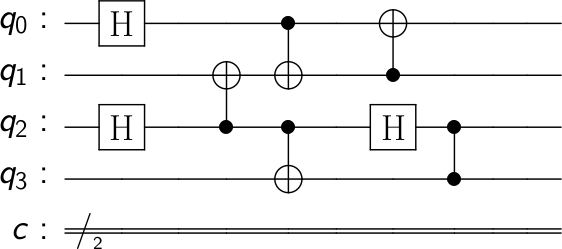

None

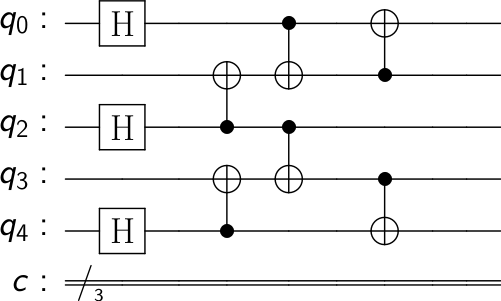

None

In [9]:
qc_Bell = codBell()
lis_Bell=[1, 2]
mes_Bell=[0, 3]
creg_Bell=[0, 1]

qc_GHZ = codGHZ()
lis_GHZ=[1, 3]
mes_GHZ=[0, 2, 4]
creg_GHZ=[0, 1, 3]

display(qc_Bell.draw(output = 'latex', plot_barriers=False),
        print("Profundidad del Circuito, estado de Bell: ", qc_Bell.depth()),
        qc_GHZ.draw(output = 'latex', plot_barriers=False),
        print("Profundidad del Circuito, estado GHZ: ", qc_GHZ.depth())
       )


Statevector([0.35355339+0.j, 0.        +0.j, 0.35355339+0.j,
             0.        +0.j, 0.35355339+0.j, 0.        +0.j,
             0.35355339+0.j, 0.        +0.j, 0.        +0.j,
             0.35355339+0.j, 0.        +0.j, 0.35355339+0.j,
             0.        +0.j, 0.35355339+0.j, 0.        +0.j,
             0.35355339+0.j],
            dims=(2, 2, 2, 2))
Statevector([0.35355339+0.j, 0.        +0.j, 0.35355339+0.j,
             0.        +0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.        +0.j, 0.35355339+0.j,
             0.        +0.j, 0.35355339+0.j, 0.        +0.j,
             0.        +0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.        +0.j, 0.        +0.j,
             0.35355339+0.j, 0.        +0.j, 0.35355339+0.j,
             0.        +0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.        +0.j, 0.35355339+0.j,
             0.        +

None

C:\ProgramData\Anaconda3\envs\MyEnv\lib\site-packages\qiskit\visualization\state_visualization.py:705: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, _ = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


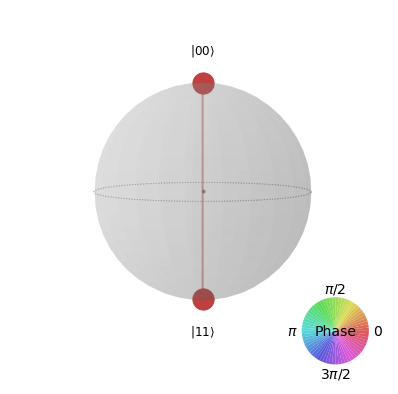

None

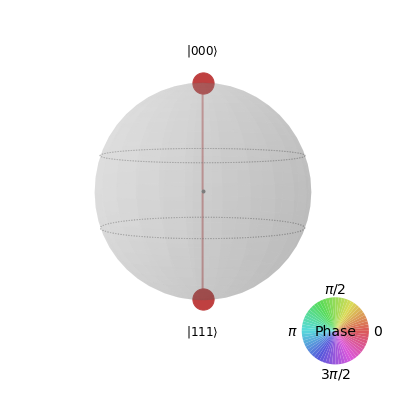

In [10]:
svs = BasicAer.get_backend('statevector_simulator')

qc_Bell_svs = execute(qc_Bell, svs).result()
qc_Bell_P  = qi.DensityMatrix(qc_Bell_svs.get_statevector(qc_Bell))
qc_Bell_sv = qi.Statevector.from_instruction(qc_Bell)

qc_GHZ_svs = execute(qc_GHZ, svs).result()
qc_GHZ_P  = qi.DensityMatrix(qc_GHZ_svs.get_statevector(qc_GHZ))
qc_GHZ_sv = qi.Statevector.from_instruction(qc_GHZ)

display(print(qc_Bell_sv),
        #qc_P.draw(output='qsphere'),
        qi.partial_trace(qc_Bell_P, lis_Bell).draw(output='qsphere'),
        #plot_state_city(qc_P),
        #plot_state_hinton(qc_P),
        print(qc_GHZ_sv),
        #qc_P.draw(output='qsphere'),
        qi.partial_trace(qc_GHZ_P, lis_GHZ).draw(output='qsphere'),
        #plot_state_city(qc_P),
        #plot_state_hinton(qc_P)
       )



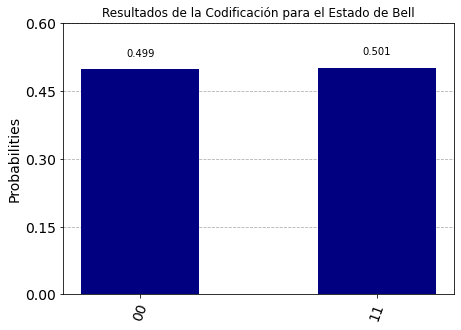

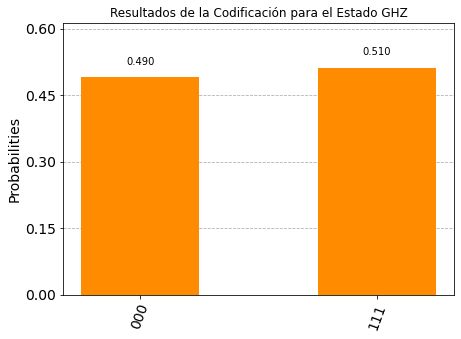

In [11]:
qc_Bell_meas = qc_Bell.copy()
qc_Bell_meas.measure(mes_Bell, [i for i in range(qc_Bell.cregs[0].size)])
qc_GHZ_meas = qc_GHZ.copy()
qc_GHZ_meas.measure(mes_GHZ, [i for i in range(qc_GHZ.cregs[0].size)])

sim = Aer.get_backend('qasm_simulator')

counts_Bell = execute(qc_Bell_meas, backend = sim, shots = shots).result().get_counts()
counts_GHZ = execute(qc_GHZ_meas, backend = sim, shots = shots).result().get_counts()

display(plth(counts_Bell,
             title='Resultados de la Codificación para el Estado de Bell',
             color=[
                 'navy'
             ],
             figsize=(7, 5)
            ),
        plth(counts_GHZ,
             title='Resultados de la Codificación para el Estado GHZ',
             color=[
                 'darkorange'
             ],
             figsize=(7, 5)
            )
       )


In [66]:
print('Cuentas de la codificación para el estado de Bell: \n',counts_Bell)
for i in counts_Bell:
    print(i, ': ',counts_Bell[i], '/\\\\',round(counts_Bell[i]/shots, 5))
print('\nCuentas de la codificación para el estado GHZ: \n',counts_GHZ)
for i in counts_GHZ:
    print(i, ': ',counts_GHZ[i], '/\\\\',round(counts_GHZ[i]/shots, 5))


Cuentas de la codificación para el estado de Bell: 
 {'11': 4007, '00': 4185}
11 :  4007 /\\ 0.48914
00 :  4185 /\\ 0.51086

Cuentas de la codificación para el estado GHZ: 
 {'000': 4073, '111': 4119}
000 :  4073 /\\ 0.49719
111 :  4119 /\\ 0.50281


In [13]:
# Bell State
# Transpile the circuit for the sistems basis gates
tqc_Bell_sim_b = transpile(qc_Bell, qcomp_sim_B)
tqc_Bell_sim_b_sv = qi.Statevector.from_instruction(tqc_Bell_sim_b)
tqc_Bell_sim_b_meas = tqc_Bell_sim_b.copy()
tqc_Bell_sim_b_meas.measure(mes_Bell, [i for i in range(tqc_Bell_sim_b_meas.cregs[0].size)])

tqc_Bell_sim_s = transpile(qc_Bell, qcomp_sim_S)
tqc_Bell_sim_s_sv = qi.Statevector.from_instruction(tqc_Bell_sim_s)
tqc_Bell_sim_s_meas = tqc_Bell_sim_s.copy()
tqc_Bell_sim_s_meas.measure(mes_Bell, [i for i in range(tqc_Bell_sim_s_meas.cregs[0].size)])

# Transpile the circuit for the sistems basis gates using the real object
tqc_Bell_b = transpile(qc_Bell, qcomp_B)
tqc_Bell_b_sv = qi.Statevector.from_instruction(tqc_Bell_b)
tqc_Bell_b_meas = tqc_Bell_b.copy()
tqc_Bell_b_meas.measure(mes_Bell, [i for i in range(tqc_Bell_b_meas.cregs[0].size)])

tqc_Bell_s = transpile(qc_Bell, qcomp_S)
tqc_Bell_s_sv = qi.Statevector.from_instruction(tqc_Bell_s)
tqc_Bell_s_meas = tqc_Bell_s.copy()
tqc_Bell_s_meas.measure(mes_Bell, [i for i in range(tqc_Bell_s_meas.cregs[0].size)])

tqc_Bell_m = transpile(qc_Bell, qcomp_M)
tqc_Bell_m_sv = qi.Statevector.from_instruction(tqc_Bell_m)
tqc_Bell_m_meas = tqc_Bell_m.copy()
tqc_Bell_m_meas.measure(mes_Bell, [i for i in range(tqc_Bell_m_meas.cregs[0].size)])

###########################################################################################
# GHZ State
# Transpile the circuit for the sistems basis gates
tqc_GHZ_sim_b = transpile(qc_GHZ, qcomp_sim_B)
tqc_GHZ_sim_b_sv = qi.Statevector.from_instruction(tqc_GHZ_sim_b)
tqc_GHZ_sim_b_meas = tqc_GHZ_sim_b.copy()
tqc_GHZ_sim_b_meas.measure(mes_GHZ, [i for i in range(tqc_GHZ_sim_b_meas.cregs[0].size)])

tqc_GHZ_sim_s = transpile(qc_GHZ, qcomp_sim_S)
tqc_GHZ_sim_s_sv = qi.Statevector.from_instruction(tqc_GHZ_sim_s)
tqc_GHZ_sim_s_meas = tqc_GHZ_sim_s.copy()
tqc_GHZ_sim_s_meas.measure(mes_GHZ, [i for i in range(tqc_GHZ_sim_s_meas.cregs[0].size)])

# Transpile the circuit for the sistems basis gates using the real object
tqc_GHZ_b = transpile(qc_GHZ, qcomp_B)
tqc_GHZ_b_sv = qi.Statevector.from_instruction(tqc_GHZ_b)
tqc_GHZ_b_meas = tqc_GHZ_b.copy()
tqc_GHZ_b_meas.measure(mes_GHZ, [i for i in range(tqc_GHZ_b_meas.cregs[0].size)])

tqc_GHZ_s = transpile(qc_GHZ, qcomp_S)
tqc_GHZ_s_sv = qi.Statevector.from_instruction(tqc_GHZ_s)
tqc_GHZ_s_meas = tqc_GHZ_s.copy()
tqc_GHZ_s_meas.measure(mes_GHZ, [i for i in range(tqc_GHZ_s_meas.cregs[0].size)])

tqc_GHZ_m = transpile(qc_GHZ, qcomp_M)
tqc_GHZ_m_sv = qi.Statevector.from_instruction(tqc_GHZ_m)
tqc_GHZ_m_meas = tqc_GHZ_m.copy()
tqc_GHZ_m_meas.measure(mes_GHZ, [i for i in range(tqc_GHZ_m_meas.cregs[0].size)])


Vector de estado del Circuito para el estado de Bell usando el sistema real:
  Statevector([3.53553391e-01+2.77555756e-16j,
             9.81307787e-18+8.83177008e-17j,
             3.53553391e-01+2.77555756e-16j,
             9.81307787e-18+8.83177008e-17j,
             3.53553391e-01+2.77555756e-16j,
             9.81307787e-18+8.83177008e-17j,
             3.53553391e-01+2.77555756e-16j,
             9.81307787e-18+8.83177008e-17j,
             0.00000000e+00+7.85046229e-17j,
             3.53553391e-01-5.55111512e-17j,
             0.00000000e+00+7.85046229e-17j,
             3.53553391e-01-5.55111512e-17j,
             0.00000000e+00+7.85046229e-17j,
             3.53553391e-01-5.55111512e-17j,
             0.00000000e+00+7.85046229e-17j,
             3.53553391e-01-5.55111512e-17j,
             0.00000000e+00+0.00000000e+00j,
             0.00000000e+00+0.00000000e+00j,
             0.00000000e+00+0.00000000e+00j,
             0.00000000e+00+0.00000000e+00j,
             0.000000

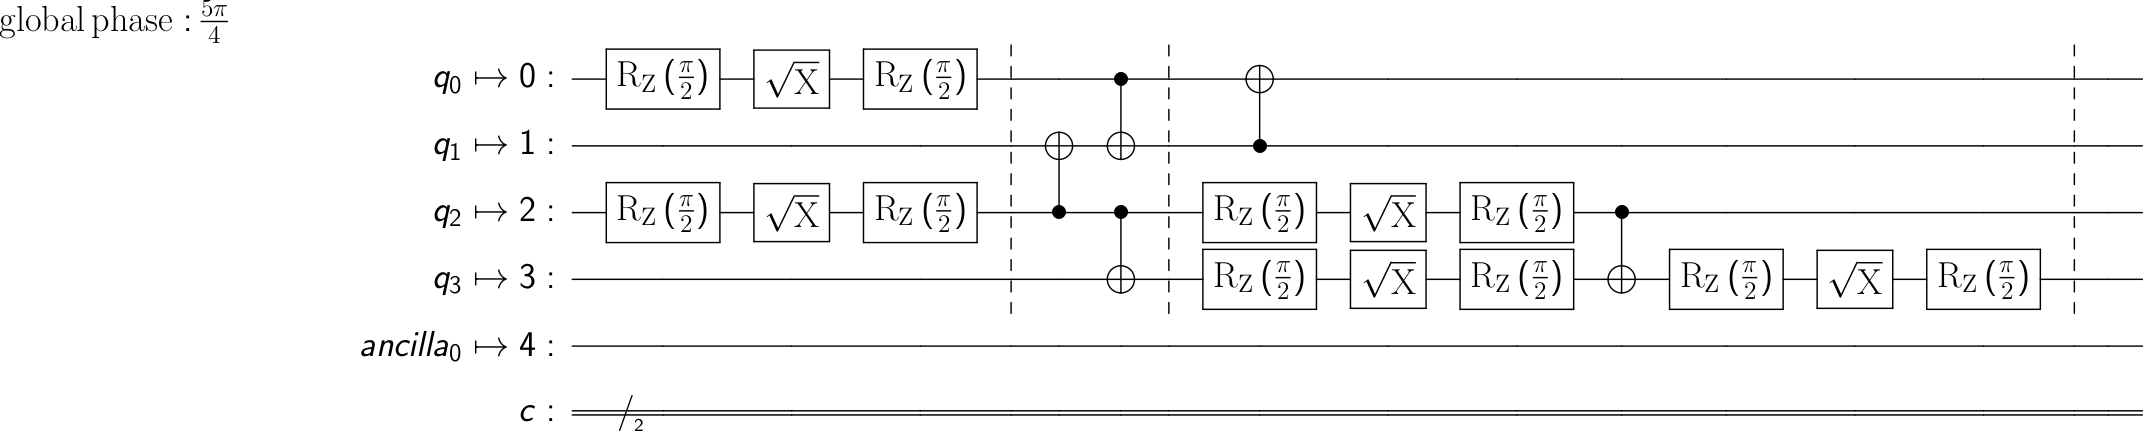

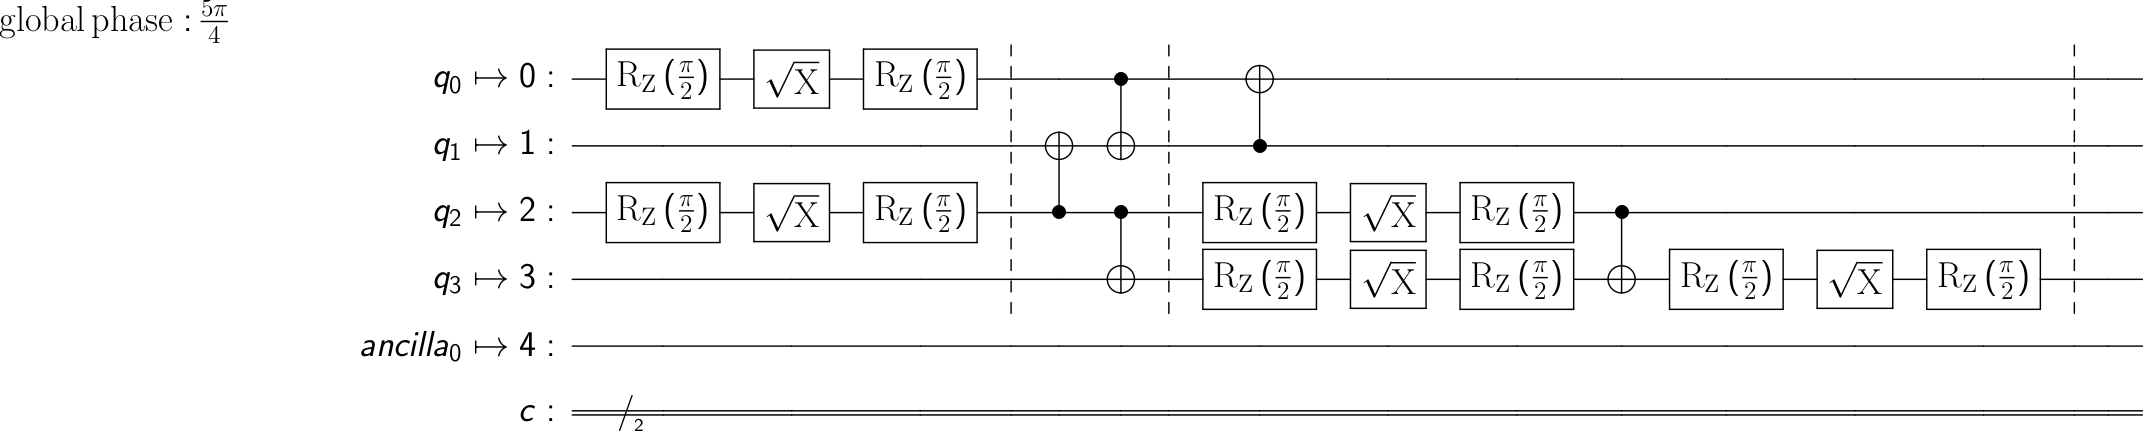

None

None

None

None

In [15]:
mpl.rcParams["figure.figsize"] = mpl.rcParamsDefault["figure.figsize"]

display(tqc_Bell_b.draw('latex'),
        tqc_Bell_sim_b.draw('latex'),
        print("Vector de estado del Circuito para el estado de Bell usando el sistema real:\n ",
              tqc_Bell_b_sv),
        print("\n\nVector de estado del Circuito para el estado de Bell usando el modelo de prueba:\n ",
              tqc_Bell_sim_b_sv),
        print("\n\nProfundidad del Circuito para el estado de Bell usando el sistema real:\n ",
              tqc_Bell_b.depth()),
        print("\n\nProfundidad del Circuito para el estado de Bell usando el modelo de prueba:\n ",
              tqc_Bell_sim_b.depth()))


Vector de estado del Circuito para el estado de Bell usando el sistema real:
  Statevector([3.53553391e-01+2.77555756e-16j,
             9.81307787e-18+8.83177008e-17j,
             3.53553391e-01+2.77555756e-16j,
             9.81307787e-18+8.83177008e-17j,
             3.53553391e-01+2.77555756e-16j,
             9.81307787e-18+8.83177008e-17j,
             3.53553391e-01+2.77555756e-16j,
             9.81307787e-18+8.83177008e-17j,
             0.00000000e+00+7.85046229e-17j,
             3.53553391e-01-5.55111512e-17j,
             0.00000000e+00+7.85046229e-17j,
             3.53553391e-01-5.55111512e-17j,
             0.00000000e+00+7.85046229e-17j,
             3.53553391e-01-5.55111512e-17j,
             0.00000000e+00+7.85046229e-17j,
             3.53553391e-01-5.55111512e-17j,
             0.00000000e+00+0.00000000e+00j,
             0.00000000e+00+0.00000000e+00j,
             0.00000000e+00+0.00000000e+00j,
             0.00000000e+00+0.00000000e+00j,
             0.000000

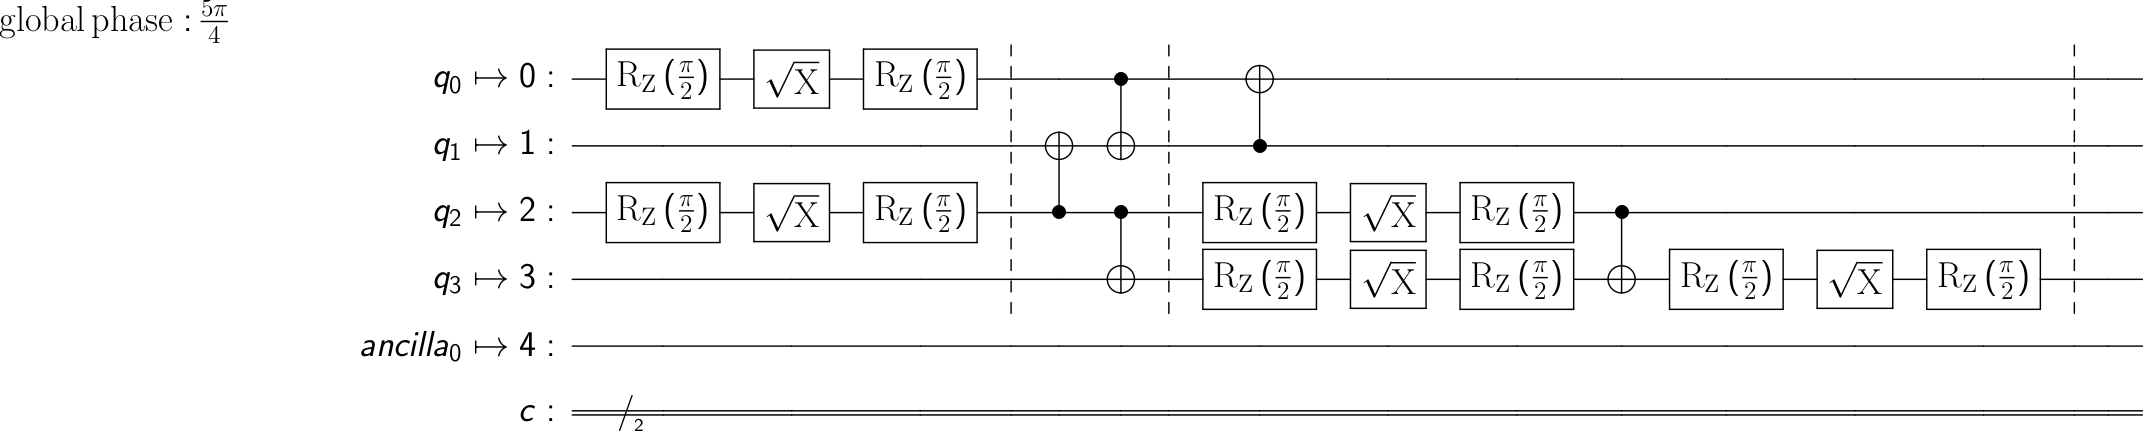

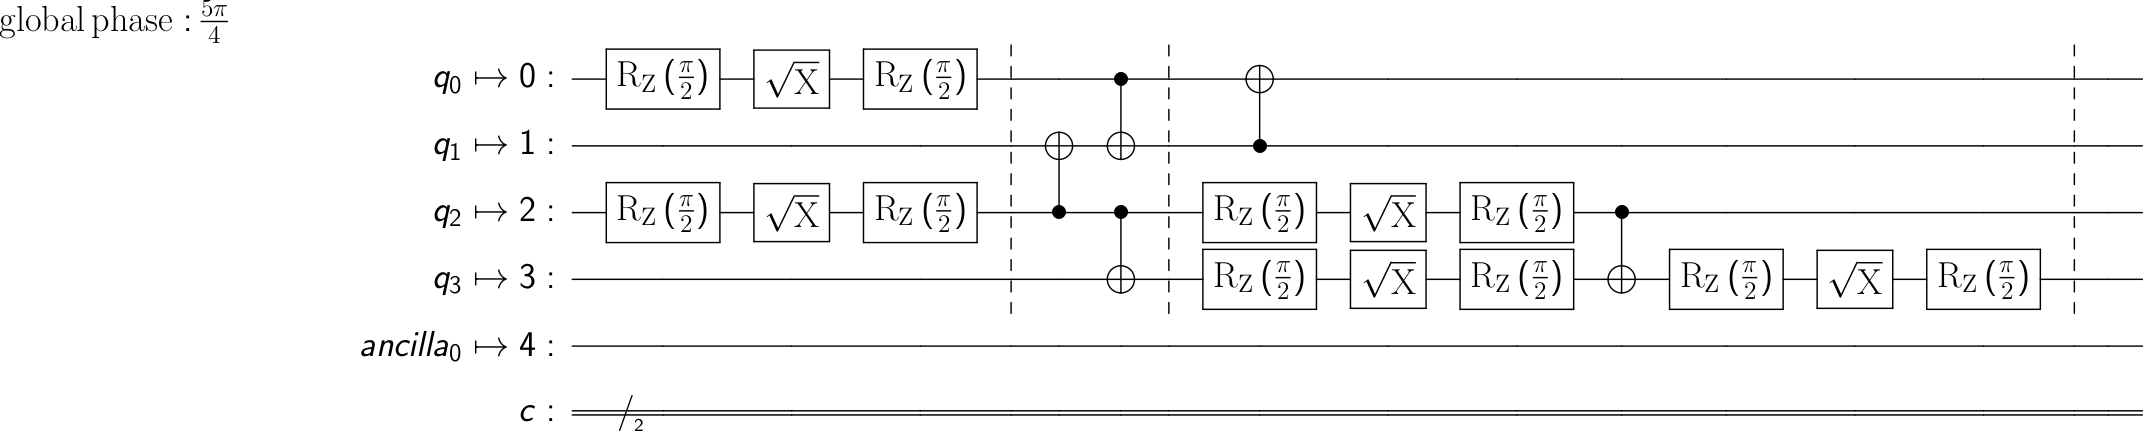

None

None

None

None

In [16]:
mpl.rcParams["figure.figsize"] = mpl.rcParamsDefault["figure.figsize"]

display(tqc_Bell_s.draw('latex'),
        tqc_Bell_sim_s.draw('latex'),
        print("Vector de estado del Circuito para el estado de Bell usando el sistema real:\n ",
              tqc_Bell_s_sv),
        print("\n\nVector de estado del Circuito para el estado de Bell usando el modelo de prueba:\n ",
              tqc_Bell_sim_s_sv),
        print("\n\nProfundidad del Circuito para el estado de Bell usando el sistema real:\n ",
              tqc_Bell_s.depth()),
        print("\n\nProfundidad del Circuito para el estado de Bell usando el modelo de prueba:\n ",
              tqc_Bell_sim_s.depth()))


Vector de estado del Circuito para el estado de Bell usando el sistema real:
  Statevector([3.53553391e-01+2.77555756e-16j,
             9.81307787e-18+8.83177008e-17j,
             3.53553391e-01+2.77555756e-16j,
             9.81307787e-18+8.83177008e-17j,
             3.53553391e-01+2.77555756e-16j,
             9.81307787e-18+8.83177008e-17j,
             3.53553391e-01+2.77555756e-16j,
             9.81307787e-18+8.83177008e-17j,
             0.00000000e+00+7.85046229e-17j,
             3.53553391e-01-5.55111512e-17j,
             0.00000000e+00+7.85046229e-17j,
             3.53553391e-01-5.55111512e-17j,
             0.00000000e+00+7.85046229e-17j,
             3.53553391e-01-5.55111512e-17j,
             0.00000000e+00+7.85046229e-17j,
             3.53553391e-01-5.55111512e-17j,
             0.00000000e+00+0.00000000e+00j,
             0.00000000e+00+0.00000000e+00j,
             0.00000000e+00+0.00000000e+00j,
             0.00000000e+00+0.00000000e+00j,
             0.000000

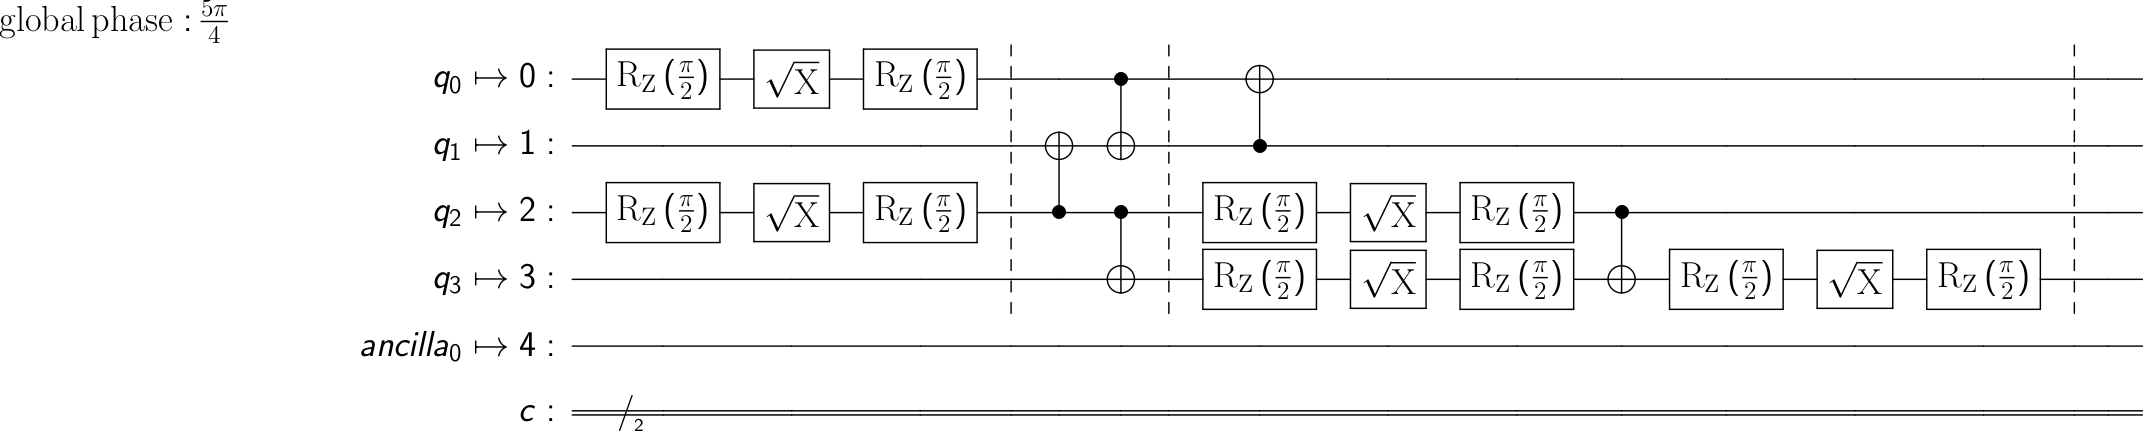

None

None

In [17]:
mpl.rcParams["figure.figsize"] = mpl.rcParamsDefault["figure.figsize"]

display(tqc_Bell_m.draw('latex'),
        print("Vector de estado del Circuito para el estado de Bell usando el sistema real:\n ",
              tqc_Bell_m_sv),
        print("\n\nProfundidad del Circuito para el estado de Bell usando el sistema real:\n ",
              tqc_Bell_m.depth()))


Vector de estado del Circuito para el estado de GHZ usando el sistema real:
  Statevector([0.35355339-5.55111512e-17j, 0.        +0.00000000e+00j,
             0.35355339-5.55111512e-17j, 0.        +0.00000000e+00j,
             0.        +0.00000000e+00j, 0.        +0.00000000e+00j,
             0.        +0.00000000e+00j, 0.        +0.00000000e+00j,
             0.35355339-5.55111512e-17j, 0.        +0.00000000e+00j,
             0.35355339-5.55111512e-17j, 0.        +0.00000000e+00j,
             0.        +0.00000000e+00j, 0.        +0.00000000e+00j,
             0.        +0.00000000e+00j, 0.        +0.00000000e+00j,
             0.        +0.00000000e+00j, 0.        +0.00000000e+00j,
             0.        +0.00000000e+00j, 0.        +0.00000000e+00j,
             0.        +0.00000000e+00j, 0.35355339-5.55111512e-17j,
             0.        +0.00000000e+00j, 0.35355339-5.55111512e-17j,
             0.        +0.00000000e+00j, 0.        +0.00000000e+00j,
             0.        +0

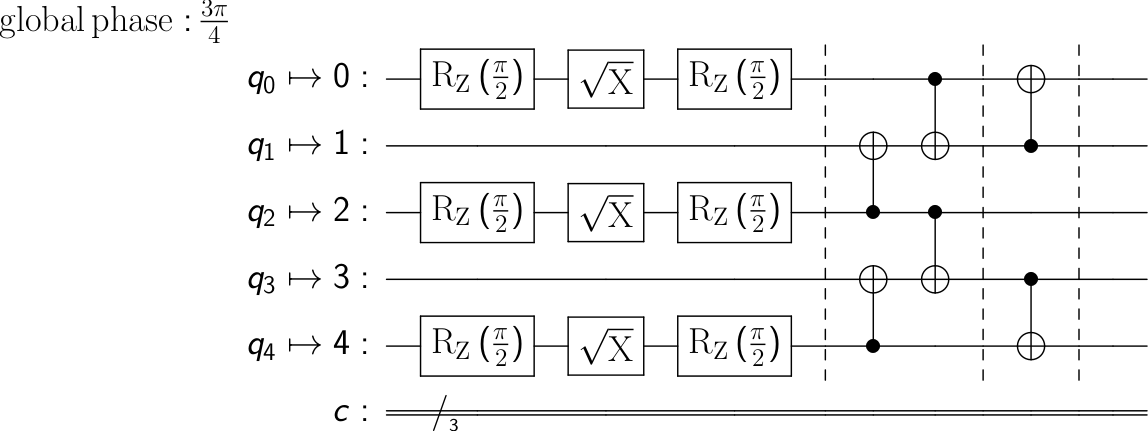

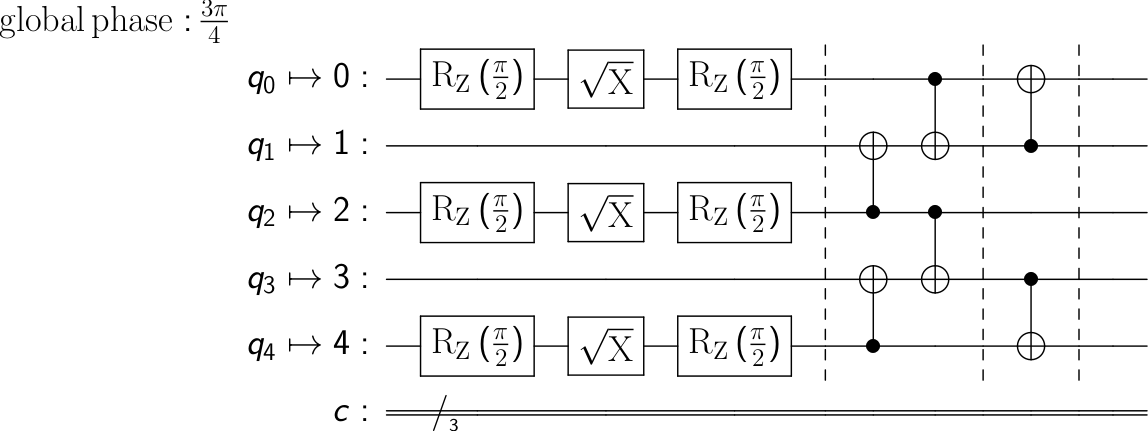

None

None

None

None

In [18]:
mpl.rcParams["figure.figsize"] = mpl.rcParamsDefault["figure.figsize"]

display(tqc_GHZ_b.draw('latex'),
        tqc_GHZ_sim_b.draw('latex'),
        print("Vector de estado del Circuito para el estado de GHZ usando el sistema real:\n ",
              tqc_GHZ_b_sv),
        print("\n\nVector de estado del Circuito para el estado de GHZ usando el modelo de prueba:\n ",
              tqc_GHZ_sim_b_sv),
        print("\n\nProfundidad del Circuito para el estado de GHZ usando el sistema real:\n ",
              tqc_GHZ_b.depth()),
        print("\n\nProfundidad del Circuito para el estado de GHZ usando el modelo de prueba:\n ",
              tqc_GHZ_sim_b.depth()))


Vector de estado del Circuito para el estado de GHZ usando el sistema real:
  Statevector([0.35355339-5.55111512e-17j, 0.        +0.00000000e+00j,
             0.35355339-5.55111512e-17j, 0.        +0.00000000e+00j,
             0.        +0.00000000e+00j, 0.        +0.00000000e+00j,
             0.        +0.00000000e+00j, 0.        +0.00000000e+00j,
             0.35355339-5.55111512e-17j, 0.        +0.00000000e+00j,
             0.35355339-5.55111512e-17j, 0.        +0.00000000e+00j,
             0.        +0.00000000e+00j, 0.        +0.00000000e+00j,
             0.        +0.00000000e+00j, 0.        +0.00000000e+00j,
             0.        +0.00000000e+00j, 0.        +0.00000000e+00j,
             0.        +0.00000000e+00j, 0.        +0.00000000e+00j,
             0.        +0.00000000e+00j, 0.35355339-5.55111512e-17j,
             0.        +0.00000000e+00j, 0.35355339-5.55111512e-17j,
             0.        +0.00000000e+00j, 0.        +0.00000000e+00j,
             0.        +0

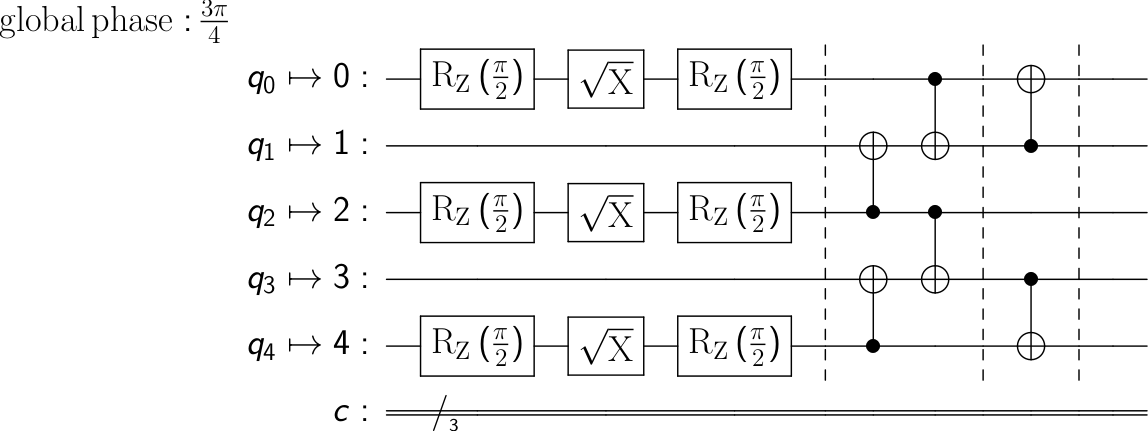

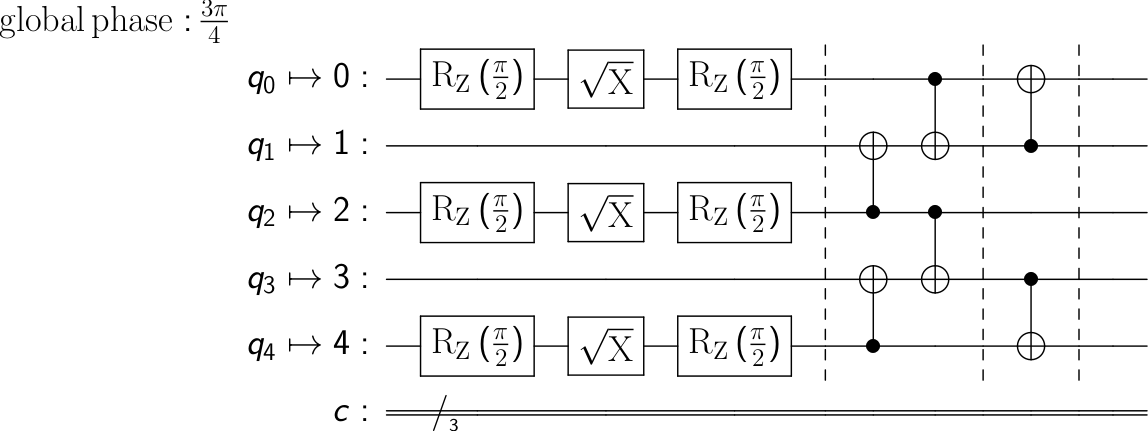

None

None

None

None

In [19]:
mpl.rcParams["figure.figsize"] = mpl.rcParamsDefault["figure.figsize"]

display(tqc_GHZ_s.draw('latex'),
        tqc_GHZ_sim_s.draw('latex'),
        print("Vector de estado del Circuito para el estado de GHZ usando el sistema real:\n ",
              tqc_GHZ_s_sv),
        print("\n\nVector de estado del Circuito para el estado de GHZ usando el modelo de prueba:\n ",
              tqc_GHZ_sim_s_sv),
        print("\n\nProfundidad del Circuito para el estado de GHZ usando el sistema real:\n ",
              tqc_GHZ_s.depth()),
        print("\n\nProfundidad del Circuito para el estado de GHZ usando el modelo de prueba:\n ",
              tqc_GHZ_sim_s.depth()))


Vector de estado del Circuito para el estado de GHZ usando el sistema real:
  Statevector([0.35355339-5.55111512e-17j, 0.        +0.00000000e+00j,
             0.35355339-5.55111512e-17j, 0.        +0.00000000e+00j,
             0.        +0.00000000e+00j, 0.        +0.00000000e+00j,
             0.        +0.00000000e+00j, 0.        +0.00000000e+00j,
             0.35355339-5.55111512e-17j, 0.        +0.00000000e+00j,
             0.35355339-5.55111512e-17j, 0.        +0.00000000e+00j,
             0.        +0.00000000e+00j, 0.        +0.00000000e+00j,
             0.        +0.00000000e+00j, 0.        +0.00000000e+00j,
             0.        +0.00000000e+00j, 0.        +0.00000000e+00j,
             0.        +0.00000000e+00j, 0.        +0.00000000e+00j,
             0.        +0.00000000e+00j, 0.35355339-5.55111512e-17j,
             0.        +0.00000000e+00j, 0.35355339-5.55111512e-17j,
             0.        +0.00000000e+00j, 0.        +0.00000000e+00j,
             0.        +0

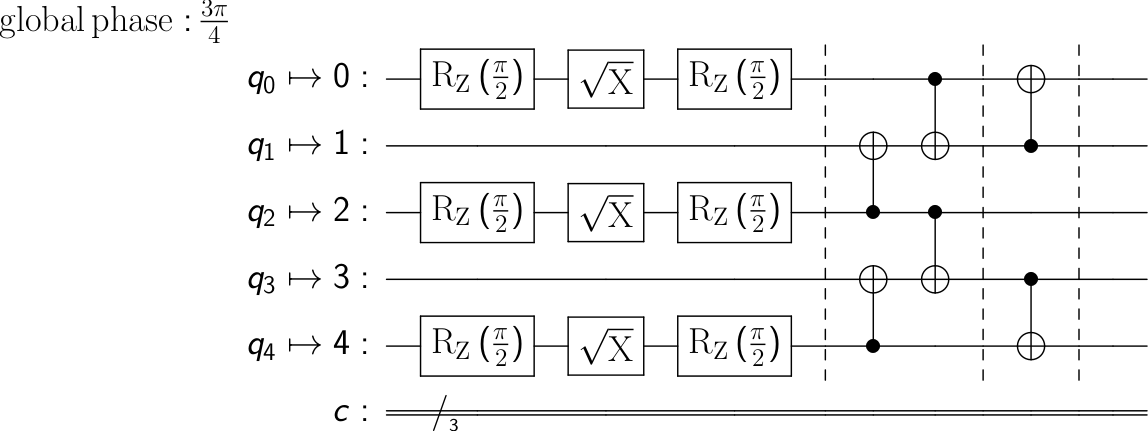

None

None

In [20]:
mpl.rcParams["figure.figsize"] = mpl.rcParamsDefault["figure.figsize"]

display(tqc_GHZ_m.draw('latex'),
        print("Vector de estado del Circuito para el estado de GHZ usando el sistema real:\n ",
              tqc_GHZ_m_sv),
        print("\n\nProfundidad del Circuito para el estado de GHZ usando el sistema real:\n ",
              tqc_GHZ_m.depth()))


In [127]:
# Bell State
#qiskit.execute(tqc_Bell_b_meas, backend=qcomp_B, shots=shots)
#qiskit.execute(tqc_Bell_s_meas, backend=qcomp_S, shots=shots)
#qiskit.execute(tqc_Bell_m_meas, backend=qcomp_M, shots=shots)

# GHZ State
#qiskit.execute(tqc_GHZ_b_meas, backend=qcomp_B, shots=shots)
#qiskit.execute(tqc_GHZ_s_meas, backend=qcomp_S, shots=shots)
#qiskit.execute(tqc_GHZ_m_meas, backend=qcomp_M, shots=shots)


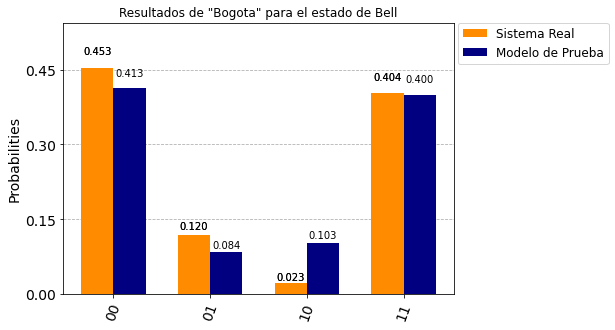

In [14]:
# Results on Bogota system
counts_Bell_b = qcomp_B.retrieve_job('61ab990fbf8803e1233095c4').result().get_counts()

# Execute noisy simulation on dummys
counts_Bell_sim_b = qcomp_sim_B.run(tqc_Bell_sim_b_meas, shots=shots).result().get_counts(tqc_Bell_sim_b_meas)

plth(
    [counts_Bell_b,
     counts_Bell_sim_b
    ],
    legend=['Sistema Real',
            'Modelo de Prueba'
           ],
    title='Resultados de "Bogota" para el estado de Bell',
    color=['darkorange',
           'navy'
          ],
    figsize=(7, 5)
)

In [42]:
print('Cuentas de la codificación para el estado de Bell en el sistema real "Bogota": \n',counts_Bell_b)
for i in counts_Bell_b:
    print(i, ': ',counts_Bell_b[i], '/',counts_Bell_b[i]/shots)
print('\nCuentas de la codificación para el estado de Bell en el sistema de prueba: \n',counts_Bell_sim_b)
for i in counts_Bell_sim_b:
    print(i, ': ',counts_Bell_sim_b[i], '/',counts_Bell_sim_b[i]/shots)


Cuentas de la codificación para el estado de Bell en el sistema real "Bogota": 
 {'00': 3715, '01': 980, '10': 190, '11': 3307}
00 :  3715 / 0.4534912109375
01 :  980 / 0.11962890625
10 :  190 / 0.023193359375
11 :  3307 / 0.4036865234375

Cuentas de la codificación para el estado de Bell en el sistema de prueba: 
 {'00': 3380, '11': 3276, '01': 690, '10': 846}
00 :  3380 / 0.41259765625
11 :  3276 / 0.39990234375
01 :  690 / 0.084228515625
10 :  846 / 0.103271484375


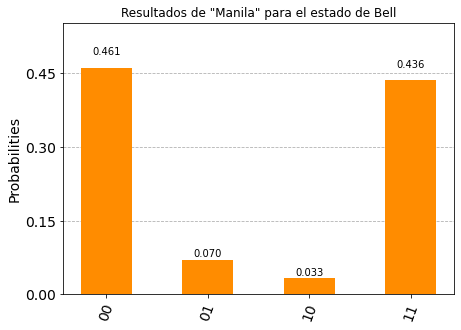

In [16]:
# Execute circuit on Manila system
counts_Bell_m = qcomp_M.retrieve_job('61ab99152e6f456fc89c7b79').result().get_counts()

plth(
    [counts_Bell_m
    ],
    title='Resultados de "Manila" para el estado de Bell',
    color=['darkorange',
          ],
    figsize=(7, 5)
)

In [43]:
print('Cuentas de la codificación para el estado de Bell en el sistema real "Manila": \n',counts_Bell_m)
for i in counts_Bell_m:
    print(i, ': ',counts_Bell_m[i], '/',counts_Bell_m[i]/shots)

Cuentas de la codificación para el estado de Bell en el sistema real "Manila": 
 {'00': 3777, '01': 571, '10': 272, '11': 3572}
00 :  3777 / 0.4610595703125
01 :  571 / 0.0697021484375
10 :  272 / 0.033203125
11 :  3572 / 0.43603515625


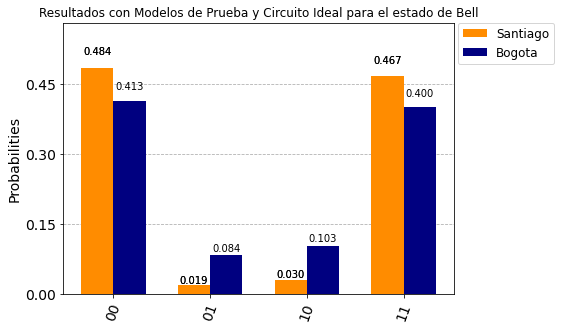

In [18]:
# Execute noisy simulation on dummys
counts_Bell_sim_s = qcomp_sim_S.run(tqc_Bell_sim_s_meas, shots=shots).result().get_counts(tqc_Bell_sim_s_meas)

plth(
    [counts_Bell_sim_s,
     counts_Bell_sim_b
    ],
    legend=['Santiago',
            'Bogota'
           ],
    title='Resultados con Modelos de Prueba y Circuito Ideal para el estado de Bell',
    color=['darkorange',
           'navy'
          ],
    figsize=(7, 5)
)

In [44]:
print('Cuentas de la codificación para el estado de Bell en el modelo de prueba de "Bogota": \n',counts_Bell_sim_b)
for i in counts_Bell_sim_b:
    print(i, ': ',counts_Bell_sim_b[i], '/',counts_Bell_sim_b[i]/shots)
print('\nCuentas de la codificación para el estado de Bell en el modelo de prueba de "Santiago": \n',counts_Bell_sim_s)
for i in counts_Bell_sim_s:
    print(i, ': ',counts_Bell_sim_s[i], '/',counts_Bell_sim_s[i]/shots)


Cuentas de la codificación para el estado de Bell en el modelo de prueba de "Bogota": 
 {'00': 3380, '11': 3276, '01': 690, '10': 846}
00 :  3380 / 0.41259765625
11 :  3276 / 0.39990234375
01 :  690 / 0.084228515625
10 :  846 / 0.103271484375

Cuentas de la codificación para el estado de Bell en el modelo de prueba de "Santiago": 
 {'00': 3966, '11': 3822, '01': 155, '10': 249}
00 :  3966 / 0.484130859375
11 :  3822 / 0.466552734375
01 :  155 / 0.0189208984375
10 :  249 / 0.0303955078125


In [56]:
for i in range(len(counts_Bell_sim_b)):
    print('{0:02b}'.format(i), ' ',counts_Bell_b['{0:02b}'.format(i)], '/',
          round(counts_Bell_b['{0:02b}'.format(i)]/shots, 5), ' ',
          counts_Bell_sim_b['{0:02b}'.format(i)], '/',
          round(counts_Bell_sim_b['{0:02b}'.format(i)]/shots, 5), ' ',
          counts_Bell_m['{0:02b}'.format(i)], '/',
          round(counts_Bell_m['{0:02b}'.format(i)]/shots, 5), ' ',
          counts_Bell_sim_s['{0:02b}'.format(i)], '/',
          round(counts_Bell_sim_s['{0:02b}'.format(i)]/shots, 5)
         )

00   3715 / 0.45349   3380 / 0.4126   3777 / 0.46106   3966 / 0.48413
01   980 / 0.11963   690 / 0.08423   571 / 0.0697   155 / 0.01892
10   190 / 0.02319   846 / 0.10327   272 / 0.0332   249 / 0.0304
11   3307 / 0.40369   3276 / 0.3999   3572 / 0.43604   3822 / 0.46655


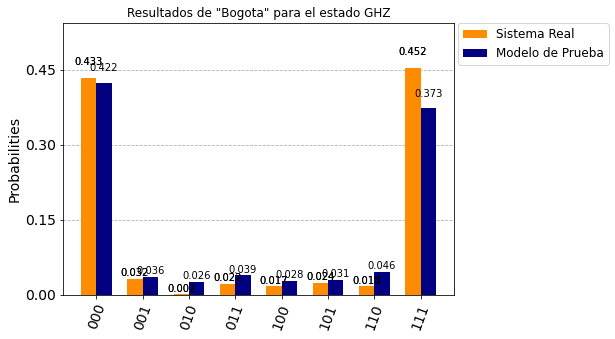

In [20]:
# Execute circuit on Bogota system
counts_GHZ_b = qcomp_B.retrieve_job('61ab99172e6f45181d9c7b7a').result().get_counts()

# Execute noisy simulation on dummys
counts_GHZ_sim_b = qcomp_sim_B.run(tqc_GHZ_sim_b_meas, shots=shots).result().get_counts(tqc_GHZ_sim_b_meas)

plth(
    [counts_GHZ_b,
     counts_GHZ_sim_b
    ],
    legend=['Sistema Real',
            'Modelo de Prueba'
           ],
    title='Resultados de "Bogota" para el estado GHZ',
    color=['darkorange',
           'navy'
          ],
    figsize=(7, 5)
)

In [45]:
print('Cuentas de la codificación para el estado GHZ en el sistema real "Bogota": \n',counts_GHZ_b)
for i in counts_GHZ_b:
    print(i, ': ',counts_GHZ_b[i], '/',counts_GHZ_b[i]/shots)
print('\nCuentas de la codificación para el estado GHZ en el sistema de prueba: \n',counts_GHZ_sim_b)
for i in counts_GHZ_sim_b:
    print(i, ': ',counts_GHZ_sim_b[i], '/',counts_GHZ_sim_b[i]/shots)


Cuentas de la codificación para el estado GHZ en el sistema real "Bogota": 
 {'000': 3548, '001': 260, '010': 15, '011': 184, '100': 140, '101': 197, '110': 145, '111': 3703}
000 :  3548 / 0.43310546875
001 :  260 / 0.03173828125
010 :  15 / 0.0018310546875
011 :  184 / 0.0224609375
100 :  140 / 0.01708984375
101 :  197 / 0.0240478515625
110 :  145 / 0.0177001953125
111 :  3703 / 0.4520263671875

Cuentas de la codificación para el estado GHZ en el sistema de prueba: 
 {'000': 3460, '010': 211, '111': 3052, '001': 292, '011': 319, '100': 233, '110': 374, '101': 251}
000 :  3460 / 0.42236328125
010 :  211 / 0.0257568359375
111 :  3052 / 0.37255859375
001 :  292 / 0.03564453125
011 :  319 / 0.0389404296875
100 :  233 / 0.0284423828125
110 :  374 / 0.045654296875
101 :  251 / 0.0306396484375


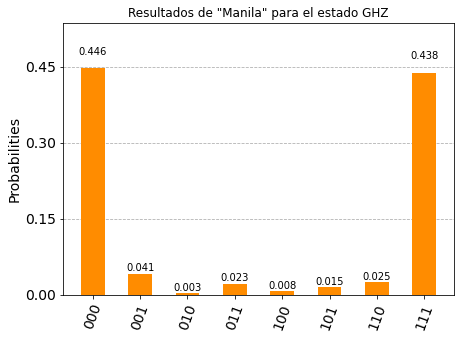

In [28]:
# Execute circuit on Manila system
counts_GHZ_m = qcomp_M.retrieve_job('61ab991bbd9cd2115456ab17').result().get_counts()

plth(
    [counts_GHZ_m
    ],
    title='Resultados de "Manila" para el estado GHZ',
    color=['darkorange',
          ],
    figsize=(7, 5)
)

In [46]:
print('Cuentas de la codificación para el estado GHZ en el sistema real "Manila": \n',counts_GHZ_m)
for i in counts_GHZ_m:
    print(i, ': ',counts_GHZ_m[i], '/',counts_GHZ_m[i]/shots)
    

Cuentas de la codificación para el estado GHZ en el sistema real "Manila": 
 {'000': 3655, '001': 339, '010': 28, '011': 185, '100': 68, '101': 123, '110': 205, '111': 3589}
000 :  3655 / 0.4461669921875
001 :  339 / 0.0413818359375
010 :  28 / 0.00341796875
011 :  185 / 0.0225830078125
100 :  68 / 0.00830078125
101 :  123 / 0.0150146484375
110 :  205 / 0.0250244140625
111 :  3589 / 0.4381103515625


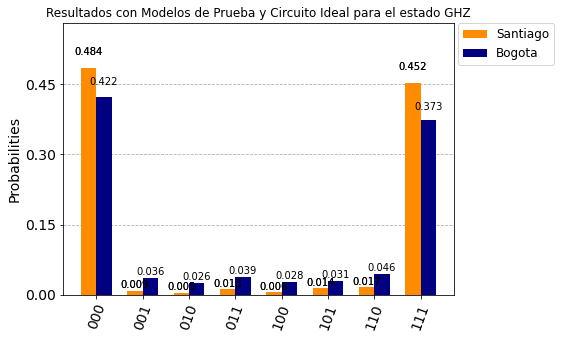

In [30]:
# Execute noisy simulation on dummys
counts_GHZ_sim_s = qcomp_sim_S.run(tqc_GHZ_sim_s_meas, shots=shots).result().get_counts(tqc_GHZ_sim_s_meas)

plth(
    [counts_GHZ_sim_s,
     counts_GHZ_sim_b
    ],
    legend=['Santiago',
            'Bogota'
           ],
    title='Resultados con Modelos de Prueba y Circuito Ideal para el estado GHZ',
    color=['darkorange',
           'navy'
          ],
    figsize=(7, 5)
)

In [47]:
print('Cuentas de la codificación para el estado GHZ en el modelo de prueba de "Bogota": \n',counts_GHZ_sim_b)
for i in counts_GHZ_sim_b:
    print(i, ': ',counts_GHZ_sim_b[i], '/',counts_GHZ_sim_b[i]/shots)
print('\nCuentas de la codificación para el estado GHZ en el modelo de prueba de "Santiago": \n',counts_GHZ_sim_s)
for i in counts_GHZ_sim_s:
    print(i, ': ',counts_GHZ_sim_s[i], '/',counts_GHZ_sim_s[i]/shots)


Cuentas de la codificación para el estado GHZ en el modelo de prueba de "Bogota": 
 {'000': 3460, '010': 211, '111': 3052, '001': 292, '011': 319, '100': 233, '110': 374, '101': 251}
000 :  3460 / 0.42236328125
010 :  211 / 0.0257568359375
111 :  3052 / 0.37255859375
001 :  292 / 0.03564453125
011 :  319 / 0.0389404296875
100 :  233 / 0.0284423828125
110 :  374 / 0.045654296875
101 :  251 / 0.0306396484375

Cuentas de la codificación para el estado GHZ en el modelo de prueba de "Santiago": 
 {'111': 3706, '000': 3961, '010': 43, '011': 108, '110': 137, '001': 75, '100': 48, '101': 114}
111 :  3706 / 0.452392578125
000 :  3961 / 0.4835205078125
010 :  43 / 0.0052490234375
011 :  108 / 0.01318359375
110 :  137 / 0.0167236328125
001 :  75 / 0.0091552734375
100 :  48 / 0.005859375
101 :  114 / 0.013916015625


In [68]:
for i in range(len(counts_GHZ_sim_b)):
    print('{0:03b}'.format(i), ' ',counts_GHZ_b['{0:03b}'.format(i)], '/',
          round(counts_GHZ_b['{0:03b}'.format(i)]/shots, 5), ' ',
          counts_GHZ_b['{0:03b}'.format(i)], '/',
          round(counts_GHZ_sim_b['{0:03b}'.format(i)]/shots, 5), ' ',
          counts_GHZ_sim_b['{0:03b}'.format(i)], '/',
          round(counts_GHZ_m['{0:03b}'.format(i)]/shots, 5), ' ',
          counts_GHZ_m['{0:03b}'.format(i)], '/',
          round(counts_GHZ_sim_s['{0:03b}'.format(i)]/shots, 5)
         )

000   3548 / 0.43311   3548 / 0.42236   3460 / 0.44617   3655 / 0.48352
001   260 / 0.03174   260 / 0.03564   292 / 0.04138   339 / 0.00916
010   15 / 0.00183   15 / 0.02576   211 / 0.00342   28 / 0.00525
011   184 / 0.02246   184 / 0.03894   319 / 0.02258   185 / 0.01318
100   140 / 0.01709   140 / 0.02844   233 / 0.0083   68 / 0.00586
101   197 / 0.02405   197 / 0.03064   251 / 0.01501   123 / 0.01392
110   145 / 0.0177   145 / 0.04565   374 / 0.02502   205 / 0.01672
111   3703 / 0.45203   3703 / 0.37256   3052 / 0.43811   3589 / 0.45239


In [124]:
t = time.time()

cal_Bell_id = ['61ac3d8fd73dea70d937350a']

tomo_Bell_id = ['61ac1f2cdcbe238349194096',
                '61ac1f382e6f45b4e69c7cac',
                '61ac1f43dcbe238996194097']

P_Bell = tomo(qc=codBell(False),
              backend=qcomp_B,
              qubits=[0, 1, 2, 3, 4],
              cal_id=cal_Bell_id,
              tomo_id=tomo_Bell_id) 

F_Bell_b = qi.state_fidelity(P_Bell[0], tqc_Bell_b_sv)
F_Bell_b_mit = qi.state_fidelity(P_Bell[2], tqc_Bell_b_sv)
print('Fidelidad en "Bogota" para el estado de Bell (s/ corrección): F = {:.5f}'.format(F_Bell_b))
print('                                             (c/ corrección): F = {:.5f}'.format(F_Bell_b_mit))
print('\n\nTiempo de ejecución (s/ corrección): t = {:.5f}'.format(P_Bell[1]))
print('                    (c/ corrección): t = {:.5f}'.format(P_Bell[3]))
print('\n\nTiempo transcurrido: t = {:.5f}'.format(time.time() - t))


Fidelidad en "Bogota" para el estado de Bell (s/ corrección): F = 0.73582
                                             (c/ corrección): F = 0.88614


Tiempo de ejecución (s/ corrección): t = 9.44874
                    (c/ corrección): t = 10.74447


Tiempo transcurrido: t = 64.07254


In [104]:
t = time.time()

cal_Bell_id = ['61ac3d76fd942634d6c6f9c5']

tomo_Bell_id = ['61ac1eacbf88031cd93096d5',
                '61ac1ec22e6f4509739c7caa',
                '61ac1eccd73dea056a3734c0']

P_Bell = tomo(qc=codBell(False),
              backend=qcomp_M,
              qubits=[0, 1, 2, 3, 4],
              cal_id=cal_Bell_id,
              tomo_id=tomo_Bell_id) 

F_Bell_m = qi.state_fidelity(P_Bell[0], tqc_Bell_m_sv)
F_Bell_m_mit = qi.state_fidelity(P_Bell[2], tqc_Bell_m_sv)
print('Fidelidad en "Manila" para el estado de Bell (s/ corrección): F = {:.5f}'.format(F_Bell_m))
print('                                             (c/ corrección): F = {:.5f}'.format(F_Bell_m_mit))
print('\n\nTiempo de ejecución [minutos] (s/ corrección): t = {:.5f}'.format(P_Bell[1]))
print('                              (c/ corrección): t = {:.5f}'.format(P_Bell[3]))
print('\n\nTiempo transcurrido [segundos] : t = {:.5f}'.format(time.time() - t))


Fidelidad en "Manila" para el estado de Bell (s/ corrección): F = 0.84050
                                             (c/ corrección): F = 0.95999


Tiempo de ejecución [minutos] (s/ corrección): t = 9.28769
                              (c/ corrección): t = 10.54921


Tiempo transcurrido [segundos] : t = 25.65036


In [125]:
t = time.time()

P_Bell_sim = tomo(qc=codBell(False),
              backend=qcomp_sim_B,
              qubits=[0, 1, 2, 3, 4]) 

F_Bell_sim_b = qi.state_fidelity(P_Bell_sim[0], tqc_Bell_sim_b_sv)
F_Bell_sim_b_mit = qi.state_fidelity(P_Bell_sim[2], tqc_Bell_sim_b_sv)
print('Fidelidad en el Modelo de prueba de "Bogota" para el estado de Bell (s/ corrección): F = {:.5f}'.format(F_Bell_sim_b))
print('                                                                    (c/ corrección): F = {:.5f}'.format(F_Bell_sim_b_mit))
print('\n\nTiempo de ejecución [minutos] (s/ corrección): t = {:.5f}'.format(P_Bell[1]))
print('                              (c/ corrección): t = {:.5f}'.format(P_Bell[3]))
print('\n\nTiempo transcurrido [segundos] : t = {:.5f}'.format(time.time() - t))


Fidelidad en el Modelo de prueba de "Bogota" para el estado de Bell (s/ corrección): F = 0.64857
                                                                    (c/ corrección): F = 0.78967


Tiempo de ejecución [minutos] (s/ corrección): t = 9.44874
                              (c/ corrección): t = 10.74447


Tiempo transcurrido [segundos] : t = 58.87644


In [108]:
t = time.time()

P_Bell_sim = tomo(qc=codBell(False),
              backend=qcomp_sim_S,
              qubits=[0, 1, 2, 3, 4]) 

F_Bell_sim_s = qi.state_fidelity(P_Bell_sim[0], tqc_Bell_sim_s_sv)
F_Bell_sim_s_mit = qi.state_fidelity(P_Bell_sim[2], tqc_Bell_sim_s_sv)
print('Fidelidad en el Modelo de prueba de "Santiago" para el estado de Bell (s/ corrección): F = {:.5f}'.format(F_Bell_sim_s))
print('                                                                      (c/ corrección): F = {:.5f}'.format(F_Bell_sim_s_mit))
print('\n\nTiempo de ejecución [minutos] (s/ corrección): t = {:.5f}'.format(P_Bell[1]))
print('                              (c/ corrección): t = {:.5f}'.format(P_Bell[3]))
print('Tiempo transcurrido [segundos] : t = {:.5f}'.format(time.time() - t))




Fidelidad en el Modelo de prueba de "Santiago" para el estado de Bell (s/ corrección): F = 0.89849
                                                                          (c/ corrección): F = 0.96767


Tiempo de ejecución [minutos] (s/ corrección): t = 9.28769
                              (c/ corrección): t = 10.54921
Tiempo transcurrido [segundos] : t = 62.95752


In [22]:
t = time.time()

cal_GHZ_id = ['61ac3d8fd73dea70d937350a']

tomo_GHZ_id = ['61ac31c7fd94260a65c6f9a2',
                '61ac330fa880fe7e566459a0',
                '61ac332aa880fe8c4a6459a2']

P_GHZ = tomo(qc=codGHZ(False),
              backend=qcomp_B,
              qubits=[0, 1, 2, 3, 4],
              cal_id=cal_GHZ_id,
              tomo_id=tomo_GHZ_id) 

F_GHZ_b = qi.state_fidelity(P_GHZ[0], tqc_GHZ_b_sv)
F_GHZ_b_mit = qi.state_fidelity(P_GHZ[2], tqc_GHZ_b_sv)
print('Fidelidad en "Bogota" para el estado GHZ (s/ corrección): F = {:.5f}'.format(F_GHZ_b))
print('                                             (c/ corrección): F = {:.5f}'.format(F_GHZ_b_mit))
print('\n\nTiempo de ejecución (s/ corrección): t = {:.5f}'.format(P_GHZ[1]))
print('                    (c/ corrección): t = {:.5f}'.format(P_GHZ[3]))
print('\n\nTiempo transcurrido: t = {:.5f}'.format(time.time() - t))


C:\ProgramData\Anaconda3\envs\MyEnv\lib\site-packages\qiskit\ignis\verification\tomography\basis\circuits.py:468: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  prep += circuit
C:\ProgramData\Anaconda3\envs\MyEnv\lib\site-packages\qiskit\circuit\quantumcircuit.py:876: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)
C:\ProgramData\Anaconda3\envs\MyEnv\lib\site-packages\qiskit\ignis\verification\tomography\basis\circuits.py:478: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  circ = prep + meas
C:\Prog

Fidelidad en "Bogota" para el estado GHZ (s/ corrección): F = 0.74953
                                             (c/ corrección): F = 0.86675


Tiempo de ejecución (s/ corrección): t = 9.45601
                    (c/ corrección): t = 10.75174


Tiempo transcurrido: t = 20.24972


In [23]:
t = time.time()

cal_GHZ_id = ['61ac3d76fd942634d6c6f9c5']

tomo_GHZ_id = ['61ac2b1df15b03c37e9a2151',
                '61ac2b29bd9cd22ef656ac67',
                '61ac2b34bd9cd2beb656ac68']

P_GHZ = tomo(qc=codGHZ(False),
              backend=qcomp_M,
              qubits=[0, 1, 2, 3, 4],
              cal_id=cal_GHZ_id,
              tomo_id=tomo_GHZ_id) 

F_GHZ_m = qi.state_fidelity(P_GHZ[0], tqc_GHZ_m_sv)
F_GHZ_m_mit = qi.state_fidelity(P_GHZ[2], tqc_GHZ_m_sv)
print('Fidelidad en "Manila" para el estado GHZ (s/ corrección): F = {:.5f}'.format(F_GHZ_m))
print('                                             (c/ corrección): F = {:.5f}'.format(F_GHZ_m_mit))
print('\n\nTiempo de ejecución [minutos] (s/ corrección): t = {:.5f}'.format(P_GHZ[1]))
print('                              (c/ corrección): t = {:.5f}'.format(P_GHZ[3]))
print('\n\nTiempo transcurrido [segundos] : t = {:.5f}'.format(time.time() - t))


Fidelidad en "Manila" para el estado GHZ (s/ corrección): F = 0.78607
                                             (c/ corrección): F = 0.92645


Tiempo de ejecución [minutos] (s/ corrección): t = 9.29241
                              (c/ corrección): t = 10.55393


Tiempo transcurrido [segundos] : t = 17.05634


In [24]:
t = time.time()

P_GHZ_sim = tomo(qc=codGHZ(False),
              backend=qcomp_sim_B,
              qubits=[0, 1, 2, 3, 4]) 

F_GHZ_sim_b = qi.state_fidelity(P_GHZ_sim[0], tqc_GHZ_sim_b_sv)
F_GHZ_sim_b_mit = qi.state_fidelity(P_GHZ_sim[2], tqc_GHZ_sim_b_sv)
print('Fidelidad en el Modelo de prueba de "Bogota" para el estado GHZ (s/ corrección): F = {:.5f}'.format(F_GHZ_sim_b))
print('                                                                (c/ corrección): F = {:.5f}'.format(F_GHZ_sim_b_mit))
print('\n\nTiempo de ejecución [minutos] (s/ corrección): t = {:.5f}'.format(P_GHZ[1]))
print('                              (c/ corrección): t = {:.5f}'.format(P_GHZ[3]))
print('\n\nTiempo transcurrido [segundos] : t = {:.5f}'.format(time.time() - t))


Fidelidad en el Modelo de prueba de "Bogota" para el estado GHZ (s/ corrección): F = 0.66419
                                                                (c/ corrección): F = 0.84133


Tiempo de ejecución [minutos] (s/ corrección): t = 9.29241
                              (c/ corrección): t = 10.55393


Tiempo transcurrido [segundos] : t = 28.45951


In [25]:
t = time.time()

P_GHZ_sim = tomo(qc=codGHZ(False),
              backend=qcomp_sim_S,
              qubits=[0, 1, 2, 3, 4]) 

F_GHZ_sim_s = qi.state_fidelity(P_GHZ_sim[0], tqc_GHZ_sim_s_sv)
F_GHZ_sim_s_mit = qi.state_fidelity(P_GHZ_sim[2], tqc_GHZ_sim_s_sv)
print('Fidelidad en el Modelo de prueba de "Santiago" para el estado GHZ (s/ corrección): F = {:.5f}'.format(F_GHZ_sim_s))
print('                                                                  (c/ corrección): F = {:.5f}'.format(F_GHZ_sim_s_mit))
print('\n\nTiempo de ejecución [minutos] (s/ corrección): t = {:.5f}'.format(P_GHZ[1]))
print('                              (c/ corrección): t = {:.5f}'.format(P_GHZ[3]))
print('Tiempo transcurrido [segundos] : t = {:.5f}'.format(time.time() - t))


Fidelidad en el Modelo de prueba de "Santiago" para el estado GHZ (s/ corrección): F = 0.87826
                                                                  (c/ corrección): F = 0.96613


Tiempo de ejecución [minutos] (s/ corrección): t = 9.29241
                              (c/ corrección): t = 10.55393
Tiempo transcurrido [segundos] : t = 29.14313


In [12]:
# RUIDOS Clásicos

noisy_amp = amp_noise(p=p_amp)

noisy_phs = phs_noise(p=p_phs)

noisy_dprz = dprz_noise(p=p_dprz)

print(noisy_amp)
print(noisy_phs)
print(noisy_dprz)


NoiseModel:
  Basis gates: ['cx', 'cz', 'id', 'rz', 'sx', 'u3', 'x']
  Instructions with noise: ['rz', 'sx', 'cx', 'cz', 'u3', 'x']
  All-qubits errors: ['rz', 'sx', 'x', 'u3', 'cx', 'cz']
NoiseModel:
  Basis gates: ['cx', 'cz', 'id', 'rz', 'sx', 'u3', 'x']
  Instructions with noise: ['rz', 'sx', 'cx', 'cz', 'u3', 'x']
  All-qubits errors: ['rz', 'sx', 'x', 'u3', 'cx', 'cz']
NoiseModel:
  Basis gates: ['cx', 'cz', 'id', 'rz', 'sx', 'u3', 'x']
  Instructions with noise: ['rz', 'sx', 'cx', 'cz', 'u3', 'x']
  All-qubits errors: ['rz', 'sx', 'x', 'u3', 'cx', 'cz']


In [13]:
# Simular el Ruido Clásico
sim_noise_amp = AerSimulator(noise_model=noisy_amp)
sim_noise_phs = AerSimulator(noise_model=noisy_phs)
sim_noise_dprz = AerSimulator(noise_model=noisy_dprz)
    

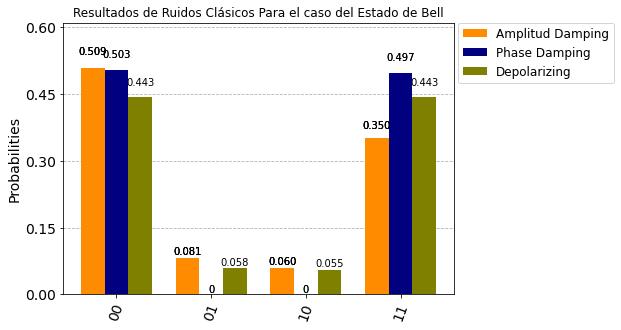

In [14]:
# Estado de Bell
tqc_Bell_noise_amp = transpile(qc_Bell, sim_noise_amp)
tqc_Bell_noise_phs = transpile(qc_Bell, sim_noise_phs)
tqc_Bell_noise_dprz = transpile(qc_Bell, sim_noise_dprz)

tqc_Bell_noise_amp_meas = tqc_Bell_noise_amp.copy()
tqc_Bell_noise_amp_meas.measure(mes_Bell,
                                [i for i in range(tqc_Bell_noise_amp_meas.cregs[0].size)])
result_Bell_noise_amp = sim_noise_amp.run(tqc_Bell_noise_amp_meas, shots=shots).result()

tqc_Bell_noise_phs_meas = tqc_Bell_noise_phs.copy()
tqc_Bell_noise_phs_meas.measure(mes_Bell,
                                [i for i in range(tqc_Bell_noise_phs_meas.cregs[0].size)])
result_Bell_noise_phs = sim_noise_phs.run(tqc_Bell_noise_phs_meas, shots=shots).result()

tqc_Bell_noise_dprz_meas = tqc_Bell_noise_dprz.copy()
tqc_Bell_noise_dprz_meas.measure(mes_Bell,
                                 [i for i in range(tqc_Bell_noise_dprz_meas.cregs[0].size)])
result_Bell_noise_dprz = sim_noise_dprz.run(tqc_Bell_noise_dprz_meas, shots=shots).result()

counts_Bell_noise_amp = result_Bell_noise_amp.get_counts(tqc_Bell_noise_amp_meas)
counts_Bell_noise_phs = result_Bell_noise_phs.get_counts(tqc_Bell_noise_phs_meas)
counts_Bell_noise_dprz = result_Bell_noise_dprz.get_counts(tqc_Bell_noise_dprz_meas)

plth(
    [counts_Bell_noise_amp,
     counts_Bell_noise_phs,
     counts_Bell_noise_dprz
    ],
    legend=['Amplitud Damping',
            'Phase Damping',
            'Depolarizing'
           ],
    title='Resultados de Ruidos Clásicos Para el caso del Estado de Bell',
    color=['darkorange',
           'navy',
           'olive'
           ],
    figsize=(7, 5)
)


In [15]:
print('Cuentas de la codificación para el estado de Bell con ruido tipo "Amplitud Damping": \n',counts_Bell_noise_amp)
for i in counts_Bell_noise_amp:
    print(i, ': ',counts_Bell_noise_amp[i], '/',counts_Bell_noise_amp[i]/shots)
print('Cuentas de la codificación para el estado de Bell con ruido tipo "Phase Damping": \n',counts_Bell_noise_phs)
for i in counts_Bell_noise_phs:
    print(i, ': ',counts_Bell_noise_phs[i], '/',counts_Bell_noise_phs[i]/shots)
print('Cuentas de la codificación para el estado de Bell con ruido tipo "Depolarizing": \n',counts_Bell_noise_dprz)
for i in counts_Bell_noise_dprz:
    print(i, ': ',counts_Bell_noise_dprz[i], '/',counts_Bell_noise_dprz[i]/shots)


Cuentas de la codificación para el estado de Bell con ruido tipo "Amplitud Damping": 
 {'11': 2871, '00': 4167, '01': 665, '10': 489}
11 :  2871 / 0.3504638671875
00 :  4167 / 0.5086669921875
01 :  665 / 0.0811767578125
10 :  489 / 0.0596923828125
Cuentas de la codificación para el estado de Bell con ruido tipo "Phase Damping": 
 {'00': 4124, '11': 4068}
00 :  4124 / 0.50341796875
11 :  4068 / 0.49658203125
Cuentas de la codificación para el estado de Bell con ruido tipo "Depolarizing": 
 {'11': 3629, '00': 3632, '01': 477, '10': 454}
11 :  3629 / 0.4429931640625
00 :  3632 / 0.443359375
01 :  477 / 0.0582275390625
10 :  454 / 0.055419921875


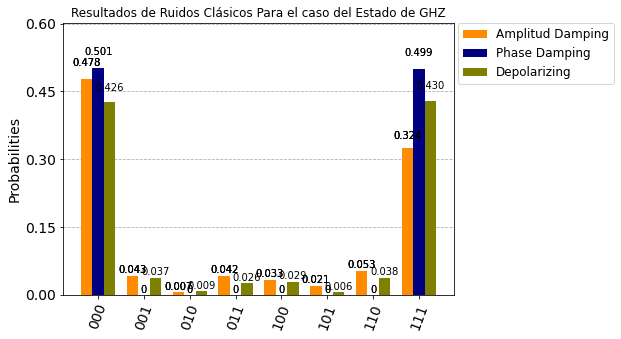

In [16]:
# Estado GHZ
tqc_GHZ_noise_amp = transpile(qc_GHZ, sim_noise_amp)
tqc_GHZ_noise_phs = transpile(qc_GHZ, sim_noise_phs)
tqc_GHZ_noise_dprz = transpile(qc_GHZ, sim_noise_dprz)

tqc_GHZ_noise_amp_meas = tqc_GHZ_noise_amp.copy()
tqc_GHZ_noise_amp_meas.measure(mes_GHZ,
                                [i for i in range(tqc_GHZ_noise_amp_meas.cregs[0].size)])
result_GHZ_noise_amp = sim_noise_amp.run(tqc_GHZ_noise_amp_meas, shots=shots).result()

tqc_GHZ_noise_phs_meas = tqc_GHZ_noise_phs.copy()
tqc_GHZ_noise_phs_meas.measure(mes_GHZ,
                                [i for i in range(tqc_GHZ_noise_phs_meas.cregs[0].size)])
result_GHZ_noise_phs = sim_noise_phs.run(tqc_GHZ_noise_phs_meas, shots=shots).result()

tqc_GHZ_noise_dprz_meas = tqc_GHZ_noise_dprz.copy()
tqc_GHZ_noise_dprz_meas.measure(mes_GHZ,
                                 [i for i in range(tqc_GHZ_noise_dprz_meas.cregs[0].size)])
result_GHZ_noise_dprz = sim_noise_dprz.run(tqc_GHZ_noise_dprz_meas, shots=shots).result()

counts_GHZ_noise_amp = result_GHZ_noise_amp.get_counts(tqc_GHZ_noise_amp_meas)
counts_GHZ_noise_phs = result_GHZ_noise_phs.get_counts(tqc_GHZ_noise_phs_meas)
counts_GHZ_noise_dprz = result_GHZ_noise_dprz.get_counts(tqc_GHZ_noise_dprz_meas)

plth(
    [counts_GHZ_noise_amp,
     counts_GHZ_noise_phs,
     counts_GHZ_noise_dprz
    ],
    legend=['Amplitud Damping',
            'Phase Damping',
            'Depolarizing'
           ],
    title='Resultados de Ruidos Clásicos Para el caso del Estado de GHZ',
    color=['darkorange',
           'navy',
           'olive'
          ],
    figsize=(7, 5)
)



In [17]:
print('Cuentas de la codificación para el estado GHZ con ruido tipo "Amplitud Damping": \n',counts_GHZ_noise_amp)
for i in counts_GHZ_noise_amp:
    print(i, ': ',counts_GHZ_noise_amp[i], '/',counts_GHZ_noise_amp[i]/shots)
print('Cuentas de la codificación para el estado GHZ con ruido tipo "Phase Damping": \n',counts_GHZ_noise_phs)
for i in counts_GHZ_noise_phs:
    print(i, ': ',counts_GHZ_noise_phs[i], '/',counts_GHZ_noise_phs[i]/shots)
print('Cuentas de la codificación para el estado GHZ con ruido tipo "Depolarizing": \n',counts_GHZ_noise_dprz)
for i in counts_GHZ_noise_dprz:
    print(i, ': ',counts_GHZ_noise_dprz[i], '/',counts_GHZ_noise_dprz[i]/shots)


Cuentas de la codificación para el estado GHZ con ruido tipo "Amplitud Damping": 
 {'111': 2658, '000': 3914, '110': 431, '001': 350, '100': 272, '011': 342, '101': 169, '010': 56}
111 :  2658 / 0.324462890625
000 :  3914 / 0.477783203125
110 :  431 / 0.0526123046875
001 :  350 / 0.042724609375
100 :  272 / 0.033203125
011 :  342 / 0.041748046875
101 :  169 / 0.0206298828125
010 :  56 / 0.0068359375
Cuentas de la codificación para el estado GHZ con ruido tipo "Phase Damping": 
 {'000': 4102, '111': 4090}
000 :  4102 / 0.500732421875
111 :  4090 / 0.499267578125
Cuentas de la codificación para el estado GHZ con ruido tipo "Depolarizing": 
 {'111': 3519, '000': 3491, '110': 310, '011': 209, '001': 304, '010': 70, '100': 237, '101': 52}
111 :  3519 / 0.4295654296875
000 :  3491 / 0.4261474609375
110 :  310 / 0.037841796875
011 :  209 / 0.0255126953125
001 :  304 / 0.037109375
010 :  70 / 0.008544921875
100 :  237 / 0.0289306640625
101 :  52 / 0.00634765625


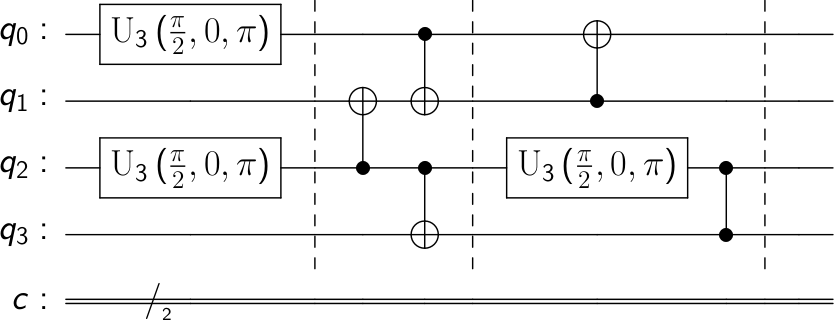

5

In [18]:
mpl.rcParams["figure.figsize"] = mpl.rcParamsDefault["figure.figsize"]
display(tqc_Bell_noise_amp.draw('latex'),
        tqc_Bell_noise_amp.depth()
       )


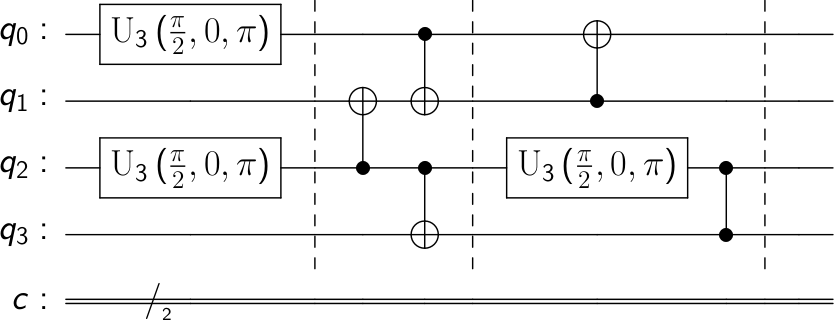

In [140]:
mpl.rcParams["figure.figsize"] = mpl.rcParamsDefault["figure.figsize"]
tqc_Bell_noise_phs.draw('latex')

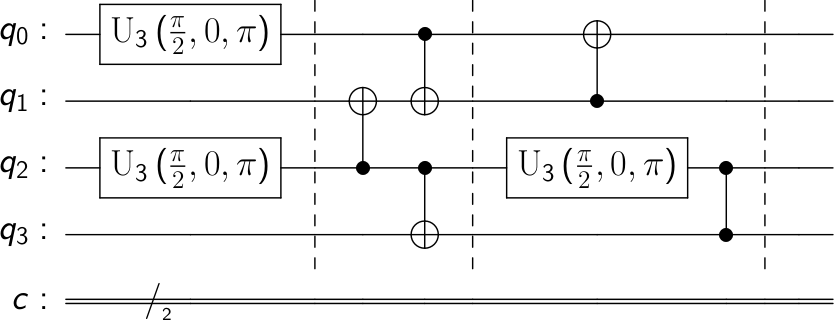

In [141]:
mpl.rcParams["figure.figsize"] = mpl.rcParamsDefault["figure.figsize"]
tqc_Bell_noise_dprz.draw('latex')

In [49]:
t = time.time()

P_amp = tomo(qc=codBell(False),
             backend=sim_noise_amp,
             qubits=[0, 1, 2, 3],
            ) 

F_amp = qi.state_fidelity(P_amp[0], qc_Bell_sv)
F_amp_mit = qi.state_fidelity(P_amp[2], qc_Bell_sv)
print('Fidelidad en el Modelo de Ruido "Amplitud Damping" para el estado de Bell (s/ corrección): F = {:.5f}'.format(F_amp))
print('                                                                          (c/ corrección): F = {:.5f}'.format(F_amp_mit))
print('\n\nTiempo de ejecución [minutos] (s/ corrección): t = {:.5f}'.format(P_amp[1]))
print('                              (c/ corrección): t = {:.5f}'.format(P_amp[3]))
print('\n\nTiempo transcurrido [segundos] : t = {:.5f}'.format(time.time() - t))


Fidelidad en el Modelo de Ruido "Amplitud Damping" para el estado de Bell (s/ corrección): F = 0.73232
                                                                          (c/ corrección): F = 0.78387


Tiempo de ejecución [minutos] (s/ corrección): t = 0.02320
                              (c/ corrección): t = 0.02764


Tiempo transcurrido [segundos] : t = 3.94146


In [39]:
t = time.time()

P_phs = tomo(qc=codBell(False),
             backend=sim_noise_phs,
             qubits=[0, 1, 2, 3],
            ) 

F_phs = qi.state_fidelity(P_phs[0], qc_Bell_sv)
F_phs_mit = qi.state_fidelity(P_phs[2], qc_Bell_sv)
print('Fidelidad en el Modelo de Ruido "Phase Damping" para el estado de Bell (s/ corrección): F = {:.5f}'.format(F_phs))
print('                                                                       (c/ corrección): F = {:.5f}'.format(F_phs_mit))
print('\n\nTiempo de ejecución [minutos] (s/ corrección): t = {:.5f}'.format(P_phs[1]))
print('                              (c/ corrección): t = {:.5f}'.format(P_phs[3]))
print('\n\nTiempo transcurrido [segundos] : t = {:.5f}'.format(time.time() - t))


Fidelidad en el Modelo de Ruido "Phase Damping" para el estado de Bell (s/ corrección): F = 0.84991
                                                                       (c/ corrección): F = 0.84991


Tiempo de ejecución [minutos] (s/ corrección): t = 0.02237
                              (c/ corrección): t = 0.04571


Tiempo transcurrido [segundos] : t = 4.70839


In [47]:
t = time.time()

P_dprz = tomo(qc=codBell(False),
             backend=sim_noise_dprz,
             qubits=[0, 1, 2, 3],
            ) 

F_dprz = qi.state_fidelity(P_dprz[0], qc_Bell_sv)
F_dprz_mit = qi.state_fidelity(P_dprz[2], qc_Bell_sv)
print('Fidelidad en el Modelo de Ruido "Depolarizing" para el estado de Bell (s/ corrección): F = {:.5f}'.format(F_dprz))
print('                                                                      (c/ corrección): F = {:.5f}'.format(F_dprz))
print('\n\nTiempo de ejecución [minutos] (s/ corrección): t = {:.5f}'.format(P_dprz[1]))
print('                              (c/ corrección): t = {:.5f}'.format(P_dprz[3]))
print('\n\nTiempo transcurrido [segundos] : t = {:.5f}'.format(time.time() - t))


C:\ProgramData\Anaconda3\envs\MyEnv\lib\site-packages\qiskit\ignis\verification\tomography\basis\circuits.py:468: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  prep += circuit
C:\ProgramData\Anaconda3\envs\MyEnv\lib\site-packages\qiskit\circuit\quantumcircuit.py:876: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)
C:\ProgramData\Anaconda3\envs\MyEnv\lib\site-packages\qiskit\ignis\verification\tomography\basis\circuits.py:478: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  circ = prep + meas
C:\Prog

Fidelidad en el Modelo de Ruido "Depolarizing" para el estado de Bell (s/ corrección): F = 0.67359
                                                                      (c/ corrección): F = 0.67359


Tiempo de ejecución [minutos] (s/ corrección): t = 0.02224
                              (c/ corrección): t = 0.04557


Tiempo transcurrido [segundos] : t = 5.29182


In [46]:
f_Bell_amp = fid(qc_Bell, tqc_Bell_noise_amp, noisy_amp, shots)
f_Bell_phs = fid(qc_Bell, tqc_Bell_noise_phs, noisy_phs, shots)
f_Bell_dprz = fid(qc_Bell, tqc_Bell_noise_dprz, noisy_dprz, shots)

print(f_Bell_amp)
print(f_Bell_phs)
print(f_Bell_dprz)

0.765004829452273
0.8475341796875001
0.7398681640625001


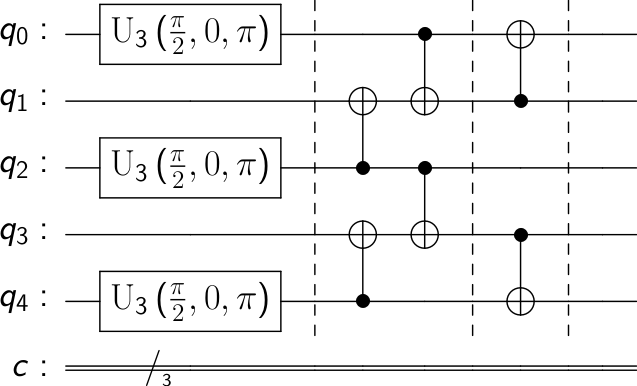

In [21]:
mpl.rcParams["figure.figsize"] = mpl.rcParamsDefault["figure.figsize"]
tqc_GHZ_noise_amp.draw('latex')

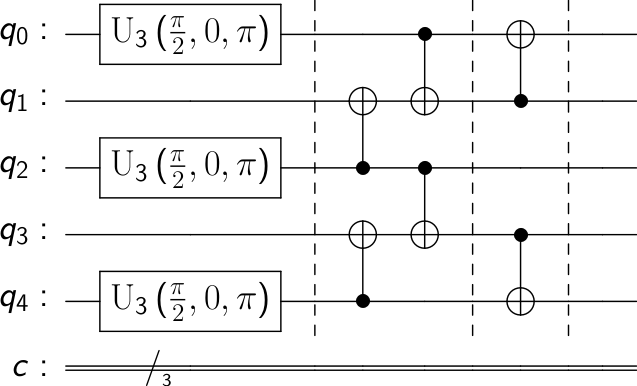

In [144]:
mpl.rcParams["figure.figsize"] = mpl.rcParamsDefault["figure.figsize"]
tqc_GHZ_noise_phs.draw('latex')

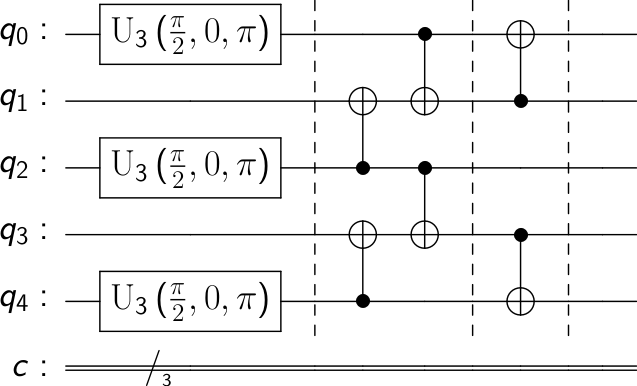

In [145]:
mpl.rcParams["figure.figsize"] = mpl.rcParamsDefault["figure.figsize"]
tqc_GHZ_noise_dprz.draw('latex')

In [45]:
t = time.time()

P_amp = tomo(qc=codGHZ(False),
             backend=sim_noise_amp,
             qubits=[0, 1, 2, 3, 4],
            ) 

F_amp = qi.state_fidelity(P_amp[0], qc_GHZ_sv)
F_amp_mit = qi.state_fidelity(P_amp[2], qc_GHZ_sv)
print('Fidelidad en el Modelo de Ruido "Amplitud Damping" para el estado GHZ (s/ corrección): F = {:.5f}'.format(F_amp))
print('                                                                      (c/ corrección): F = {:.5f}'.format(F_amp_mit))
print('\n\nTiempo de ejecución [minutos] (s/ corrección): t = {:.5f}'.format(P_amp[1]))
print('                              (c/ corrección): t = {:.5f}'.format(P_amp[3]))
print('\n\nTiempo transcurrido [segundos] : t = {:.5f}'.format(time.time() - t))


Fidelidad en el Modelo de Ruido "Amplitud Damping" para el estado GHZ (s/ corrección): F = 0.68881
                                                                      (c/ corrección): F = 0.76502


Tiempo de ejecución [minutos] (s/ corrección): t = 0.07681
                              (c/ corrección): t = 0.08720


Tiempo transcurrido [segundos] : t = 20.29040


In [46]:
t = time.time()

P_phs = tomo(qc=codGHZ(False),
             backend=sim_noise_phs,
             qubits=[0, 1, 2, 3, 4],
            ) 

F_phs = qi.state_fidelity(P_phs[0], qc_GHZ_sv)
F_phs_mit = qi.state_fidelity(P_phs[2], qc_GHZ_sv)
print('Fidelidad en el Modelo de Ruido "Phase Damping" para el estado GHZ (s/ corrección): F = {:.5f}'.format(F_phs))
print('                                                                   (c/ corrección): F = {:.5f}'.format(F_phs_mit))
print('\n\nTiempo de ejecución [minutos] (s/ corrección): t = {:.5f}'.format(P_phs[1]))
print('                              (c/ corrección): t = {:.5f}'.format(P_phs[3]))
print('\n\nTiempo transcurrido [segundos] : t = {:.5f}'.format(time.time() - t))


Fidelidad en el Modelo de Ruido "Phase Damping" para el estado GHZ (s/ corrección): F = 0.82763
                                                                   (c/ corrección): F = 0.82763


Tiempo de ejecución [minutos] (s/ corrección): t = 0.07985
                              (c/ corrección): t = 0.13574


Tiempo transcurrido [segundos] : t = 21.33391


In [47]:
t = time.time()

P_dprz = tomo(qc=codGHZ(False),
             backend=sim_noise_dprz,
             qubits=[0, 1, 2, 3, 4],
            ) 

F_dprz = qi.state_fidelity(P_dprz[0], qc_GHZ_sv)
F_dprz_mit = qi.state_fidelity(P_dprz[2], qc_GHZ_sv)
print('Fidelidad en el Modelo de Ruido "Depolarizing" para el estado GHZ (s/ corrección): F = {:.5f}'.format(F_dprz))
print('                                                                  (c/ corrección): F = {:.5f}'.format(F_dprz))
print('\n\nTiempo de ejecución [minutos] (s/ corrección): t = {:.5f}'.format(P_dprz[1]))
print('                              (c/ corrección): t = {:.5f}'.format(P_dprz[3]))
print('\n\nTiempo transcurrido [segundos] : t = {:.5f}'.format(time.time() - t))


Fidelidad en el Modelo de Ruido "Depolarizing" para el estado GHZ (s/ corrección): F = 0.63886
                                                                  (c/ corrección): F = 0.63886


Tiempo de ejecución [minutos] (s/ corrección): t = 0.15206
                              (c/ corrección): t = 0.20671


Tiempo transcurrido [segundos] : t = 40.49961


In [48]:
f_GHZ_amp = fid(qc_GHZ, tqc_GHZ_noise_amp, noisy_amp, shots)
f_GHZ_phs = fid(qc_GHZ, tqc_GHZ_noise_phs, noisy_phs, shots)
f_GHZ_dprz = fid(qc_GHZ, tqc_GHZ_noise_dprz, noisy_dprz, shots)

print(f_GHZ_amp)
print(f_GHZ_phs)
print(f_GHZ_dprz)

0.7310155906949173
0.8278808593750001
0.7220458984375001


In [ ]:
f_Bell_amp_sweep = []
f_Bell_phs_sweep = []
f_Bell_dprz_sweep = []
p_Bell_i = []
n = 1600

for i in range(0, n):
    p_Bell_i.append(i/n)
    print(i)
    noisy_amp_sweep = amp_noise(p=i/n)
    noisy_phs_sweep = phs_noise(p=i/n)
    noisy_dprz_sweep = dprz_noise(p=i/n)
    
    tqc_Bell_noise_amp_sweep = transpile(qc_Bell, AerSimulator(noise_model=noisy_amp))
    tqc_Bell_noise_phs_sweep = transpile(qc_Bell, AerSimulator(noise_model=noisy_phs))
    tqc_Bell_noise_dprz_sweep = transpile(qc_Bell, AerSimulator(noise_model=noisy_dprz))

    f_Bell_amp_sweep.append(fid(qc_Bell, tqc_Bell_noise_amp_sweep, noisy_amp_sweep, shots))
    f_Bell_phs_sweep.append(fid(qc_Bell, tqc_Bell_noise_phs_sweep, noisy_phs_sweep, shots))
    f_Bell_dprz_sweep.append(fid(qc_Bell, tqc_Bell_noise_dprz_sweep, noisy_dprz_sweep, shots))
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

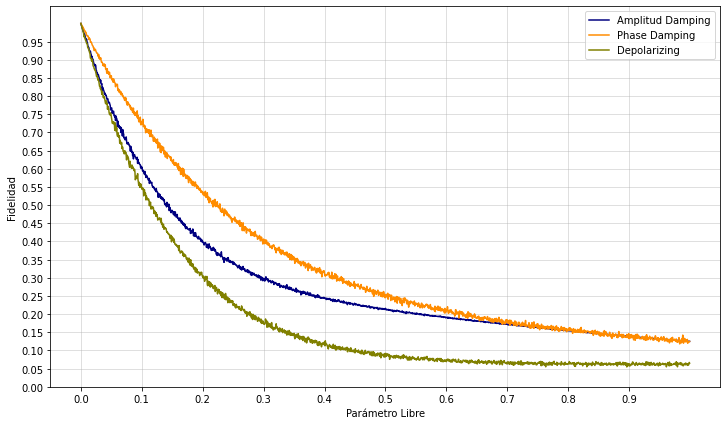

In [151]:
mpl.rcParams["figure.figsize"] = (12,7)
plt.plot(p_Bell_i, f_Bell_amp_sweep, color='navy', label='Amplitud Damping')
plt.plot(p_Bell_i, f_Bell_phs_sweep, color='darkorange', label='Phase Damping')
plt.plot(p_Bell_i, f_Bell_dprz_sweep, color='olive', label='Depolarizing')
plt.xlabel("Parámetro Libre")
plt.ylabel("Fidelidad")
plt.legend(loc='upper right');
plt.xticks(np.arange(0, 1, step=0.1))
plt.yticks(np.arange(0, 1, step=0.05))
plt.grid(alpha=0.2)
plt.grid(alpha=0.5)
plt.show()

In [152]:
f_GHZ_amp_sweep = []
f_GHZ_phs_sweep = []
f_GHZ_dprz_sweep = []
p_GHZ_i = []
n = 1600

for i in range(0, n):
    p_GHZ_i.append(i/n)
    print(i)
    noisy_amp_sweep = amp_noise(p=i/n)
    noisy_phs_sweep = phs_noise(p=i/n)
    noisy_dprz_sweep = dprz_noise(p=i/n)
    
    tqc_GHZ_noise_amp_sweep = transpile(qc_GHZ, AerSimulator(noise_model=noisy_amp))
    tqc_GHZ_noise_phs_sweep = transpile(qc_GHZ, AerSimulator(noise_model=noisy_phs))
    tqc_GHZ_noise_dprz_sweep = transpile(qc_GHZ, AerSimulator(noise_model=noisy_dprz))

    f_GHZ_amp_sweep.append(fid(qc_GHZ, tqc_GHZ_noise_amp_sweep, noisy_amp_sweep, shots))
    f_GHZ_phs_sweep.append(fid(qc_GHZ, tqc_GHZ_noise_phs_sweep, noisy_phs_sweep, shots))
    f_GHZ_dprz_sweep.append(fid(qc_GHZ, tqc_GHZ_noise_dprz_sweep, noisy_dprz_sweep, shots))
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

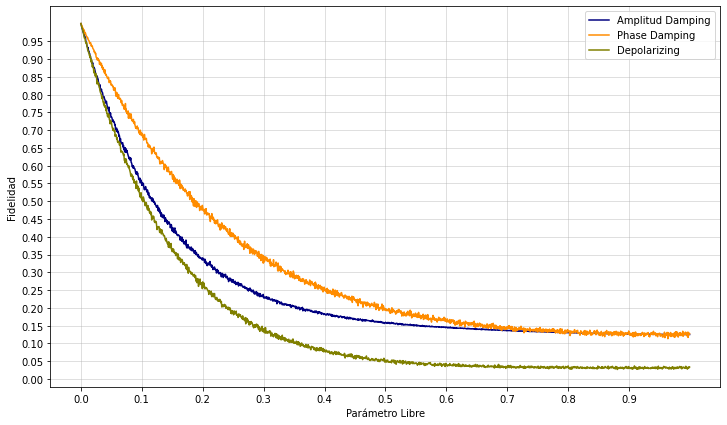

In [153]:
mpl.rcParams["figure.figsize"] = (12,7)
plt.plot(p_GHZ_i, f_GHZ_amp_sweep, color='navy', label='Amplitud Damping')
plt.plot(p_GHZ_i, f_GHZ_phs_sweep, color='darkorange', label='Phase Damping')
plt.plot(p_GHZ_i, f_GHZ_dprz_sweep, color='olive', label='Depolarizing')
plt.xlabel("Parámetro Libre")
plt.ylabel("Fidelidad")
plt.legend(loc='upper right');
plt.xticks(np.arange(0, 1, step=0.1))
plt.yticks(np.arange(0, 1, step=0.05))
plt.grid(alpha=0.2)
plt.grid(alpha=0.5)
plt.show()